# Augmented VAE training

In [1]:
%load_ext autoreload
%autoreload 2

import os


os.environ["WANDB_NOTEBOOK_NAME"] = "aug_vae.ipynb"
# os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"
# XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp

import flax
flax.config.update('flax_use_orbax_checkpointing', True)
from flax.training import checkpoints

import ciclo
import wandb 

from clu import parameter_overview
from clu import deterministic_data

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.transformations import transform_image
from experiments.configs.pgm_mnist import get_config as get_pgm_config
from experiments.configs.vae_mnist import get_config as get_vae_config
from src.utils.input import get_data
from src.models.transformation_inference_model import TransformationInferenceNet, create_transformation_inference_state, make_transformation_inference_train_and_eval
from src.utils.proto_plots import plot_proto_model_training_metrics
from src.utils.gen_plots import plot_gen_model_training_metrics, plot_gen_dists
from src.models.transformation_generative_model import TransformationGenerativeNet, make_transformation_generative_train_and_eval, create_transformation_generative_state
from src.models.aug_vae import AUG_VAE, create_aug_vae_state, make_aug_vae_train_and_eval, make_aug_vae_plotting_fns
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.training import custom_wandb_logger


/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
I0000 00:00:1700473950.286413 1051565 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
TRAIN_PGM = True

In [3]:
ANGLE = 180
pgm_config = get_pgm_config(f"{ANGLE}")
vae_config = get_vae_config(f"{ANGLE}")

In [4]:
rng = random.PRNGKey(pgm_config.seed)
data_rng, proto_init_rng, gen_init_rng, va_init_rng = random.split(rng, 4)

## Get data

In [5]:
train_ds, val_ds, _ = get_data(pgm_config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

In [6]:
# # get an example from the validation data 
# example = next(deterministic_data.start_input_pipeline(val_ds))['image'][0][14]

# plt.imshow(example, cmap='gray')
# plt.axis('off')
# plt.show()

# # now lets apply 4 random rotations to this image
# # and plot the results
# rotations = [50, 90, 110, 150, 180, 230, 300, 345, 1]
# for rot in rotations:
#     transformed = transform_image(example, jnp.array([0, 0, (rot - 90) * jnp.pi / 180, 0, 0]))
#     plt.imshow(rescale_for_imshow(transformed), cmap='gray')
#     plt.axis('off')
#     # save with same border as in plt.show
#     plt.savefig(f"rot_{rot}.png", bbox_inches='tight', pad_inches=0)
#     plt.show()

## Train PGM

In [10]:
proto_model = TransformationInferenceNet(**pgm_config.model.inference.to_dict())

proto_state = create_transformation_inference_state(proto_model, proto_init_rng, pgm_config)

INFO:absl:
+--------------------------+-------------+---------+-----------+--------+
| Name                     | Shape       | Size    | Mean      | Std    |
+--------------------------+-------------+---------+-----------+--------+
| params/Dense_0/bias      | (1024,)     | 1,024   | 0.0       | 0.0    |
| params/Dense_0/kernel    | (784, 1024) | 802,816 | -5.95e-05 | 0.0357 |
| params/Dense_1/bias      | (512,)      | 512     | 0.0       | 0.0    |
| params/Dense_1/kernel    | (1024, 512) | 524,288 | -2.79e-05 | 0.0313 |
| params/Dense_2/bias      | (256,)      | 256     | 0.0       | 0.0    |
| params/Dense_2/kernel    | (512, 256)  | 131,072 | 4.69e-05  | 0.0441 |
| params/Dense_3/bias      | (128,)      | 128     | 0.0       | 0.0    |
| params/Dense_3/kernel    | (256, 128)  | 32,768  | -3.69e-05 | 0.0626 |
| params/Dense_4/bias      | (5,)        | 5       | 0.0       | 0.0    |
| params/Dense_4/kernel    | (128, 5)    | 640     | 0.0       | 0.0    |
| params/LayerNorm_0/bias  

In [8]:
train_step, eval_step = make_transformation_inference_train_and_eval(proto_model, pgm_config)

In [11]:
if TRAIN_PGM:
    run = wandb.init(
        project="iclr2024experiments",
        entity="invariance-learners",
        config=pgm_config.to_dict(),
        mode="online",
        notes="",
        name=None,
        settings=wandb.Settings(code_dir="../"),
    )
    
    total_steps = pgm_config.inf_steps
    proto_final_state, history, _ = ciclo.train_loop(
        proto_state,
        deterministic_data.start_input_pipeline(train_ds),
        {
            ciclo.on_train_step: [
                train_step
            ],
            ciclo.on_reset_step: reset_metrics,
            ciclo.on_test_step: eval_step,
            ciclo.every(1): custom_wandb_logger(run=run)
        },
        test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
        epoch_duration=int(total_steps * pgm_config.eval_freq),
        callbacks=[
            ciclo.keras_bar(total=total_steps),
            # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
            # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
        ],
        stop=total_steps + 1,
    )
    checkpoints.save_checkpoint("inf_model", proto_final_state, proto_final_state.step, overwrite=True)
    run.finish()
else:
    proto_final_state = checkpoints.restore_checkpoint("inf_model", proto_state)

15000/15000 [==============================] - 601s 40ms/step - invertibility_loss: 0.0032 - loss: 0.0579 - x_mse: 0.0576 - η_recon_loss: 0.1334 - invertibility_loss_test: 0.0032 - loss_test: 0.0589 - x_mse_test: 0.0586 - η_recon_loss_test: 0.1329 - label_paired_image_mse_test: 0.3461        ETA: 12:09:12 - invertibility_loss: 8.0594e-04 - loss: 0.2679 - x_mse: 0.2678 - η_recon_loss: 0.5816 - invertibility_loss_test: 0.0014 - loss_test: 0.4637 - x_mse_test: 0.4636 - η_recon_loss_test: 0.5842 - label_paired_image_mse_test: 0.0000 - ETA: 6:07:25 - invertibility_loss: 7.3685e-04 - loss: 0.2632 - x_mse: 0.2631 - η_recon_loss: 0.5810 - invertibility_loss_test: 0.0014 - loss_test: 0.4637 - x_mse_test: 0.4636 - η_recon_loss_test: 0.5842 - label_paired_image_mse_test: 0.0000e+0 - ETA: 5:27:15 - invertibility_loss: 7.0951e-04 - loss: 0.2609 - x_mse: 0.2608 - η_recon_loss: 0.5804 - invertibility_loss_test: 0.0014 - loss_test: 0.4637 - x_mse_test: 0.4636 - ETA: 45:18 - invertibility_loss: 4.6063e

INFO:absl:Saving checkpoint at step: 15001
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:OCDBT is initialized successfully.
INFO:absl:Saving item to inf_model/checkpoint_15001.
INFO:absl:Renaming inf_model/checkpoint_15001.orbax-checkpoint-tmp-1700474755687863 to inf_model/checkpoint_15001
INFO:absl:Finished saving checkpoint to `inf_model/checkpoint_15001`.
INFO:absl:Removing checkpoint at inf_model/checkpoint_20001


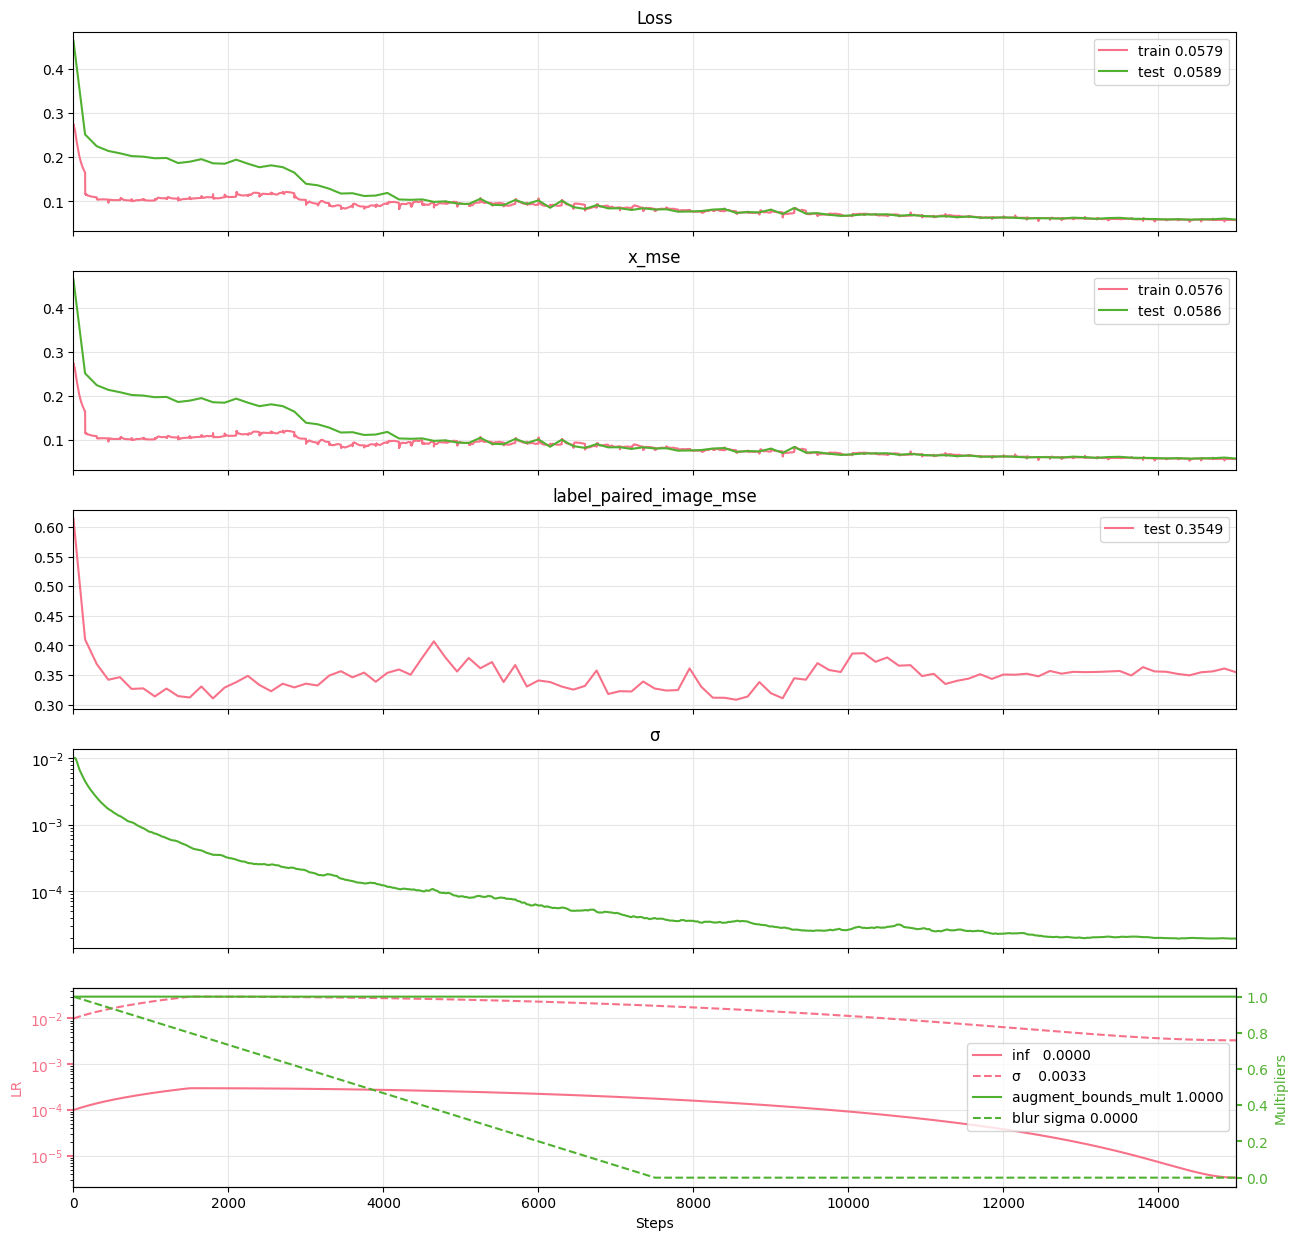

In [12]:
if TRAIN_PGM:
    fig = plot_proto_model_training_metrics(history)

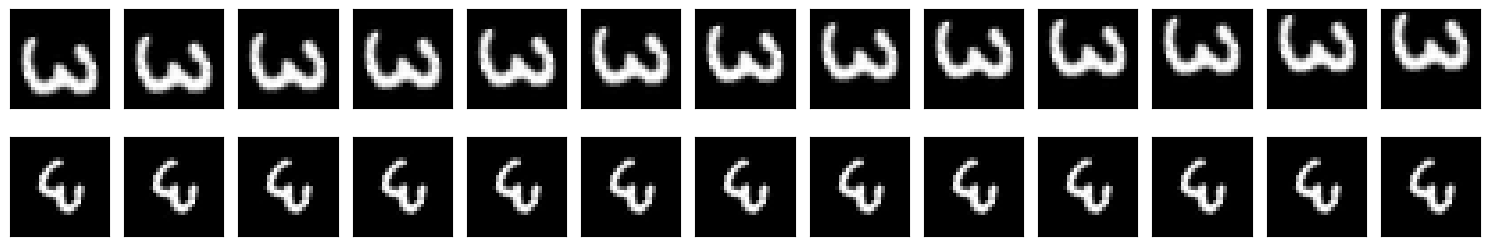

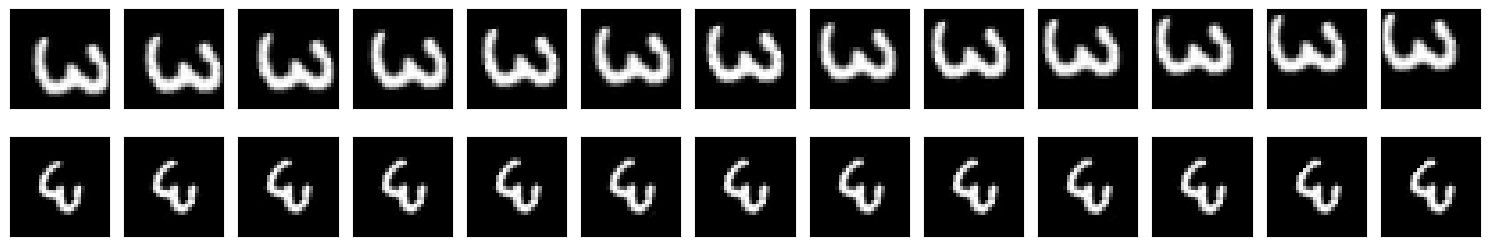

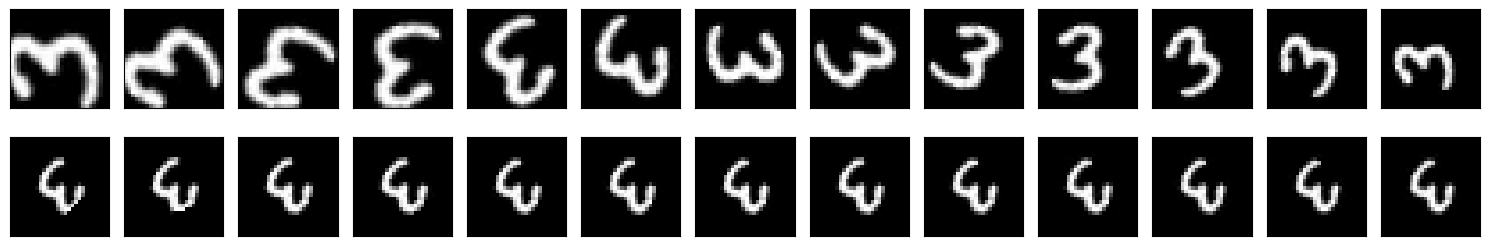

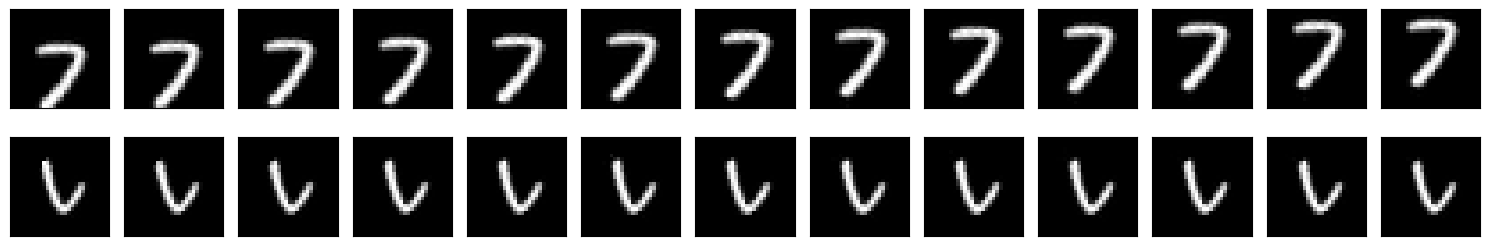

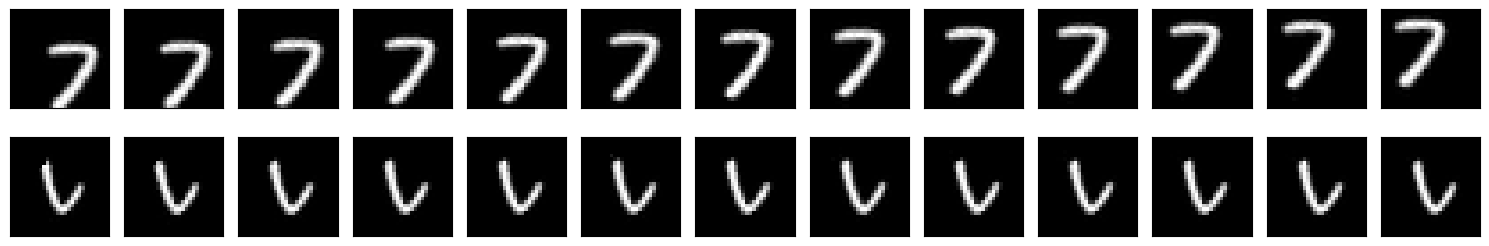

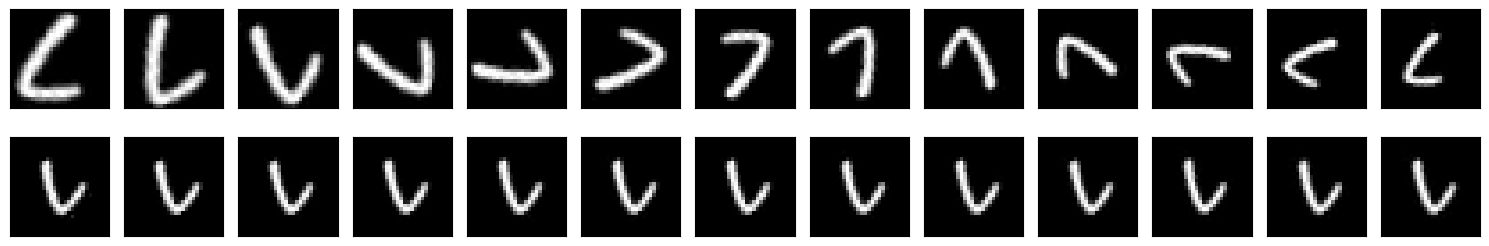

In [13]:
from src.transformations.affine import gen_affine_matrix_no_shear, transform_image_with_affine_matrix


val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

@jax.jit
def get_prototype(x):
    p_η = proto_model.apply({"params": proto_final_state.params}, x, train=False)
    η = p_η.sample(seed=rng)
    affine_matrix = gen_affine_matrix_no_shear(η)
    affine_matrix_inv = jnp.linalg.inv(affine_matrix)
    xhat = transform_image_with_affine_matrix(x, affine_matrix_inv, order=pgm_config.interpolation_order)
    return xhat, η

for x_ in [
    val_batch['image'][0][14],
    val_batch['image'][0][12],
]:
    for mask in [
        # jnp.array([0, 0, 1, 0, 0]),
        jnp.array([0, 1, 0, 0, 0]),
        jnp.array([1, 1, 0, 0, 0]),
        # jnp.array([0, 0, 0, 1, 1]),
        jnp.array([1, 1, 1, 1, 1])
    ]:

        transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
            x_,
            jnp.linspace(-jnp.array(pgm_config.augment_bounds[:5]) * mask, jnp.array(pgm_config.augment_bounds[:5]) * mask, 13)
        )

        xhats, ηs = jax.vmap(get_prototype)(transformed_xs)

        fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

        for ax, x in zip(axs[0], list(transformed_xs)):
            ax.imshow(rescale_for_imshow(x), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        for ax, xhat in zip(axs[1], list(xhats)):
            ax.imshow(rescale_for_imshow(xhat), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

In [14]:
def prototype_function(x, rng):
    η = proto_model.apply({"params": proto_final_state.params}, x, train=False).sample(seed=rng)
    return η

In [15]:
gen_model = TransformationGenerativeNet(**pgm_config.model.generative.to_dict())

gen_state = create_transformation_generative_state(gen_model, gen_init_rng, pgm_config)

INFO:absl:
+------------------------------------------------+-------------+---------+-----------+--------+
| Name                                           | Shape       | Size    | Mean      | Std    |
+------------------------------------------------+-------------+---------+-----------+--------+
| params/ConditionedConditioner_0/Dense_0/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/ConditionedConditioner_0/Dense_0/kernel | (261, 256)  | 66,816  | -0.000177 | 0.0619 |
| params/ConditionedConditioner_0/Dense_1/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/ConditionedConditioner_0/Dense_1/kernel | (256, 256)  | 65,536  | -0.000203 | 0.0622 |
| params/ConditionedConditioner_0/Dense_2/bias   | (65,)       | 65      | 0.0       | 0.0    |
| params/ConditionedConditioner_0/Dense_2/kernel | (256, 65)   | 16,640  | 0.0       | 0.0    |
| params/ConditionedConditioner_1/Dense_0/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/ConditionedCondition

In [16]:
train_step, eval_step = make_transformation_generative_train_and_eval(gen_model, pgm_config, prototype_function=prototype_function)

In [17]:
if TRAIN_PGM:
    run = wandb.init(
        project="iclr2024experiments",
        entity="invariance-learners",
        config=pgm_config.to_dict(),
        mode="online",
        notes="",
        name=None,
        settings=wandb.Settings(code_dir="../"),
    )

    gen_final_state, history, _ = ciclo.train_loop(
        gen_state,
        deterministic_data.start_input_pipeline(train_ds),
        {
            ciclo.on_train_step: [
                train_step
            ],
            ciclo.on_reset_step: reset_metrics,
            ciclo.on_test_step: eval_step,
            ciclo.every(1): custom_wandb_logger(run=run)
        },
        test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
        epoch_duration=int(pgm_config.gen_steps * pgm_config.eval_freq),
        callbacks=[
            ciclo.keras_bar(total=pgm_config.gen_steps),
            # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
            # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
        ],
        stop=pgm_config.gen_steps + 1,
    )
    run.finish()
    checkpoints.save_checkpoint("gen_model", gen_final_state, gen_final_state.step, overwrite=True)
else:
    gen_final_state = checkpoints.restore_checkpoint("gen_model", gen_state)

 1936/10000 [====>.........................] - ETA: 3:44 - log_p_η_x_hat: 5.8351 - loss: -5.7318 - mae: 0.5389 - log_p_η_x_hat_test: 5.8090 - loss_test: -5.7023 - mae_test: 0.5616

10000/10000 [==============================] - 228s 23ms/step - log_p_η_x_hat: 7.1243 - loss: -6.5778 - mae: 0.5493 - log_p_η_x_hat_test: 6.2725 - loss_test: -5.6113 - mae_test: 0.6612


INFO:absl:Saving checkpoint at step: 10001
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to gen_model/checkpoint_10001.
INFO:absl:Specified `force`: removing existing directory.
INFO:absl:Renaming gen_model/checkpoint_10001.orbax-checkpoint-tmp-1700475027801779 to gen_model/checkpoint_10001
INFO:absl:Finished saving checkpoint to `gen_model/checkpoint_10001`.


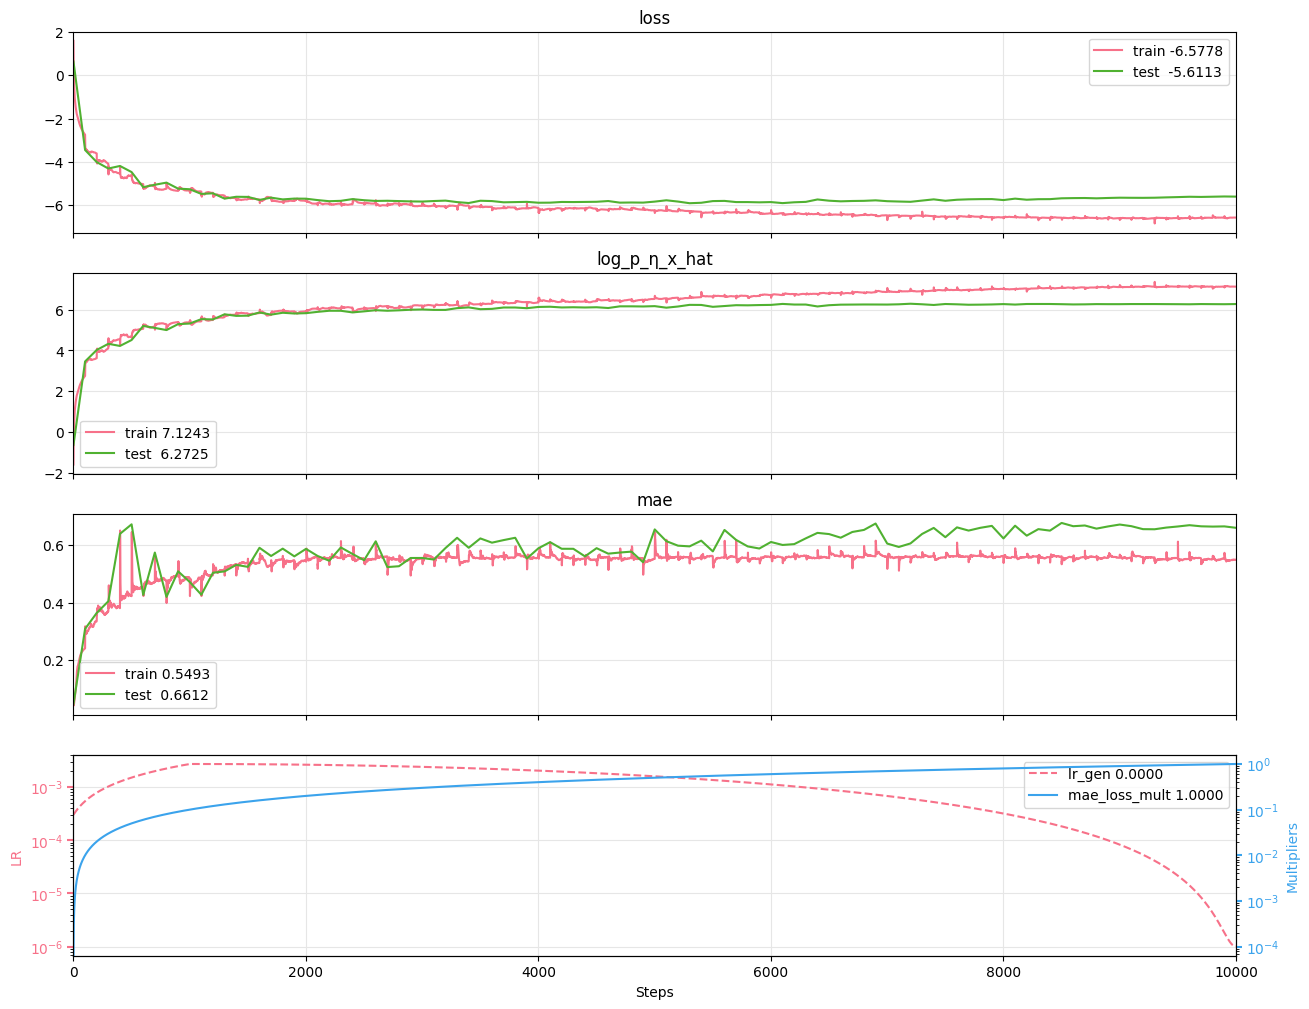

In [18]:
if TRAIN_PGM:
    fig = plot_gen_model_training_metrics(history)

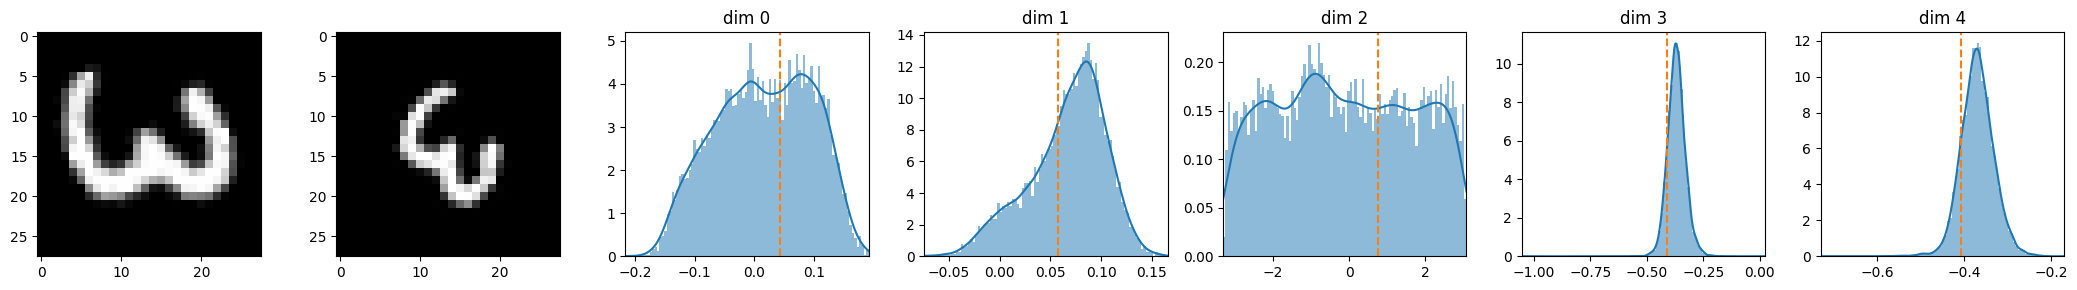

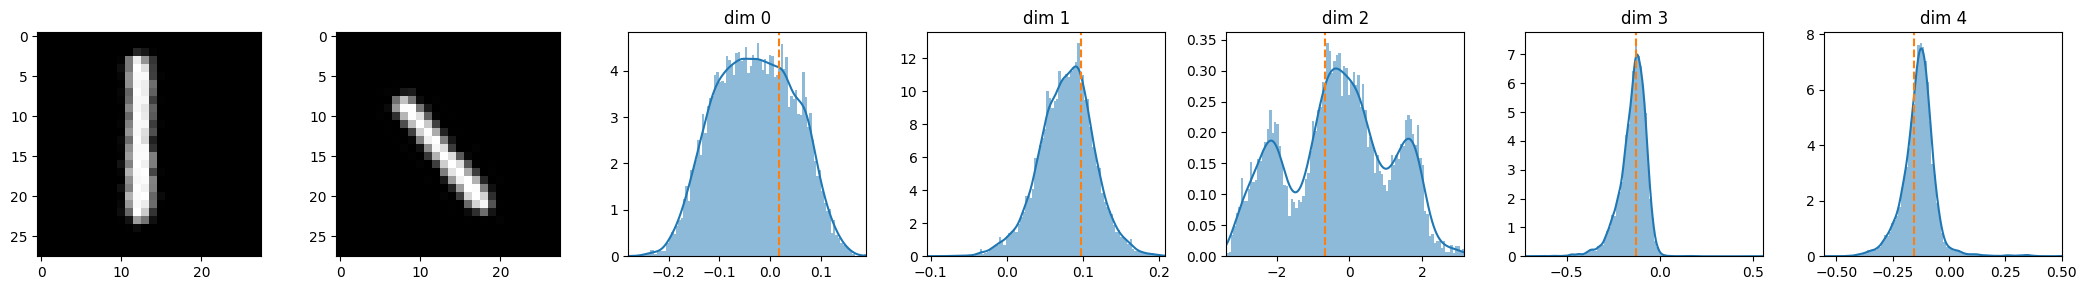

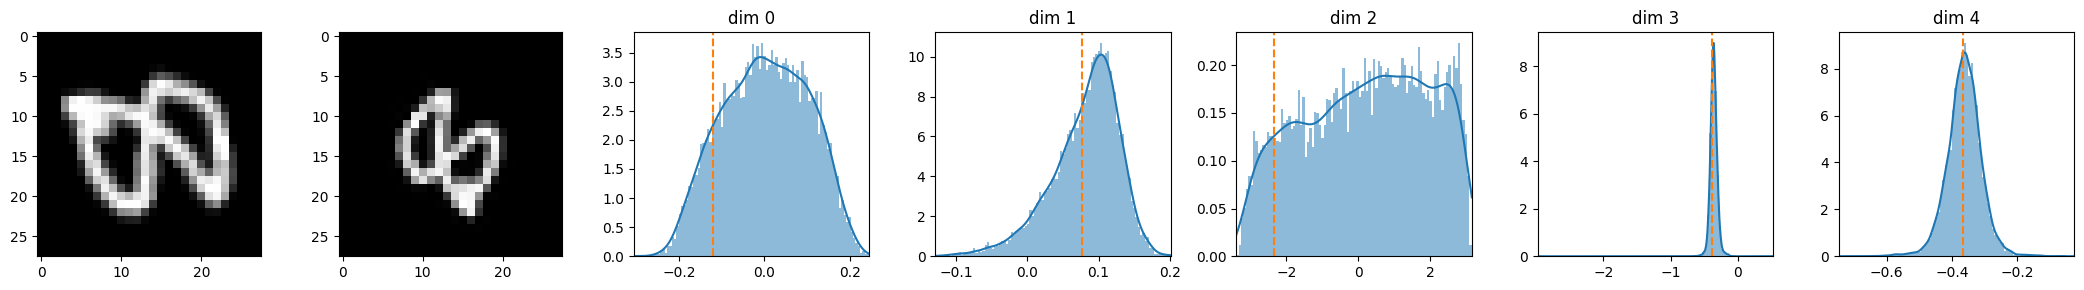

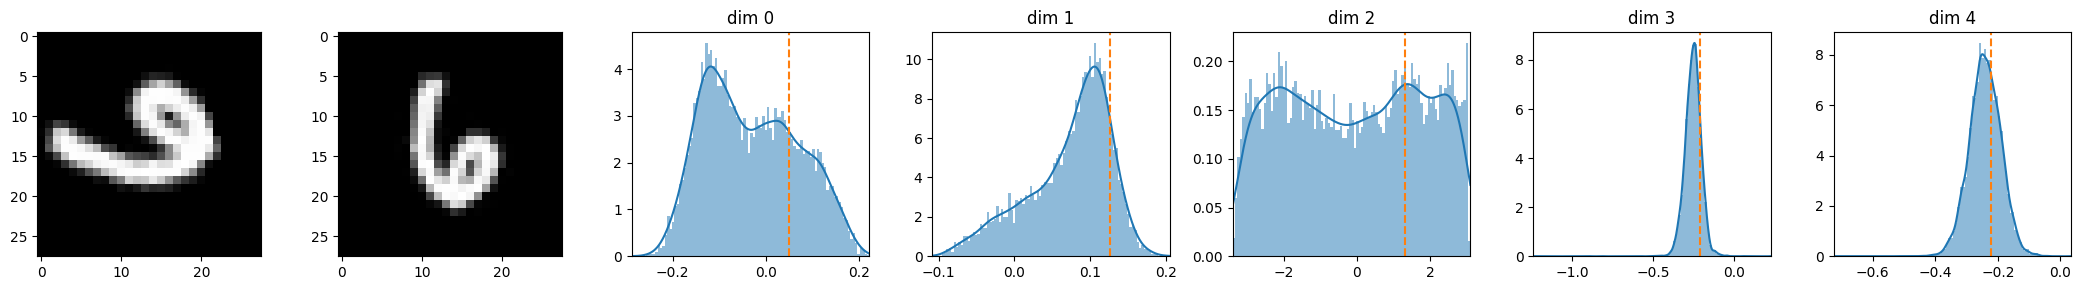

In [19]:
for x in [
            val_batch["image"][0][14],
            val_batch["image"][0][1],
            val_batch["image"][0][4],
            val_batch["image"][0][9],
        ]:
        plot_gen_dists(x, prototype_function, rng, gen_model, gen_final_state.params, pgm_config)
        plt.show()
        plt.close(fig)

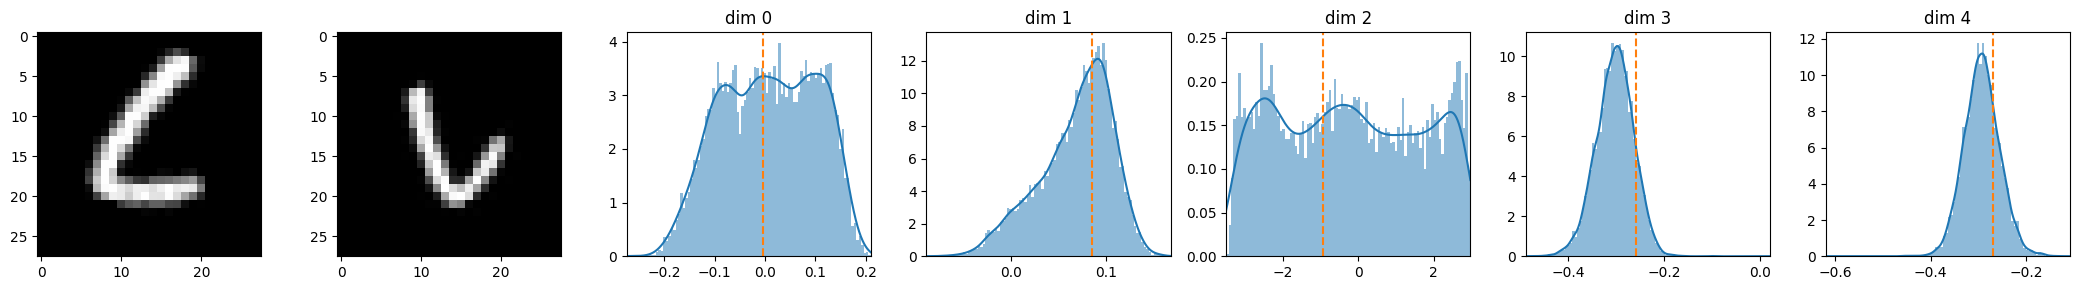

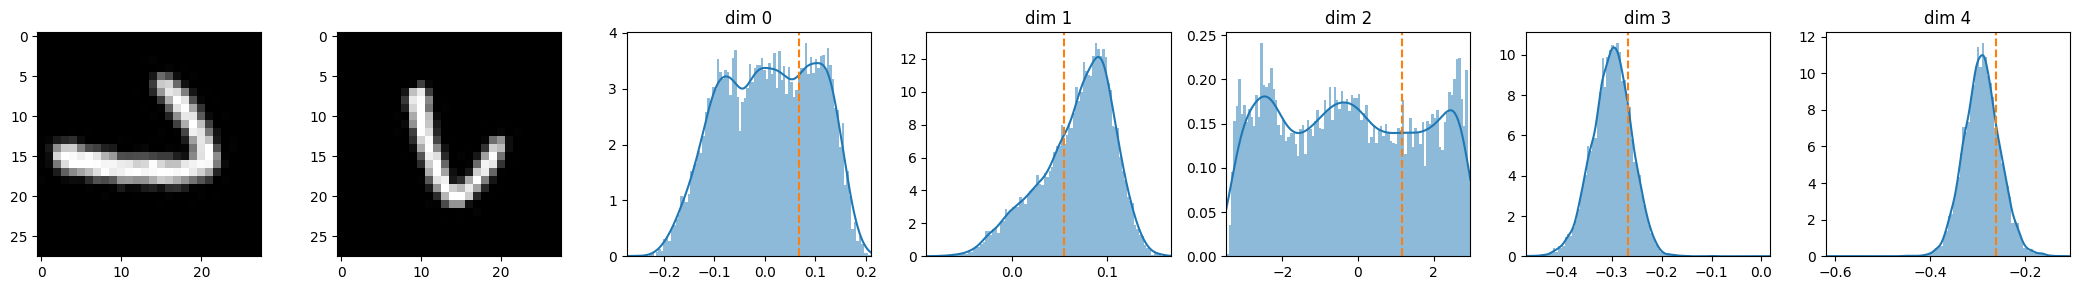

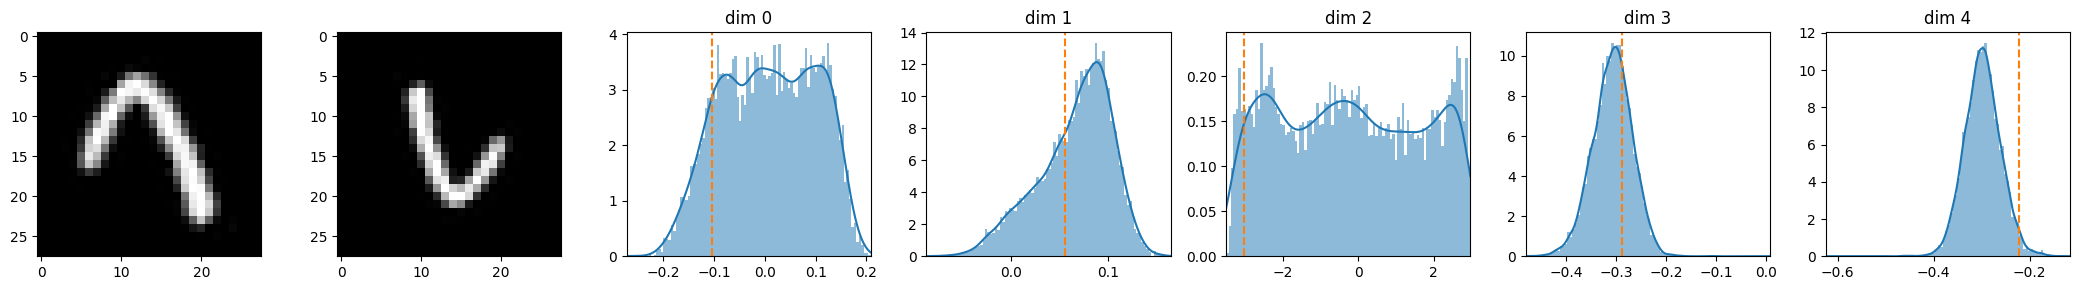

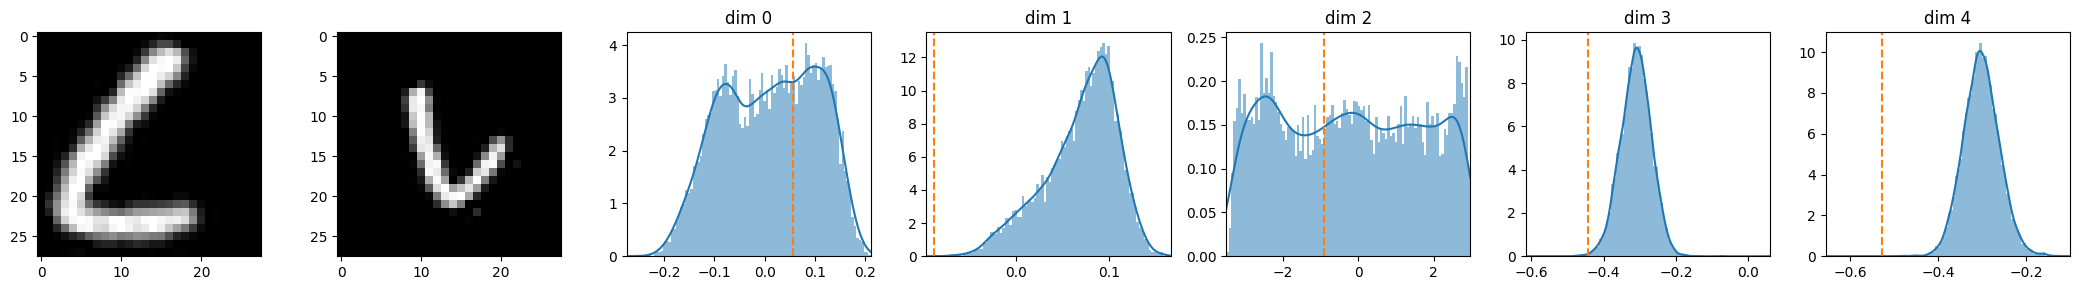

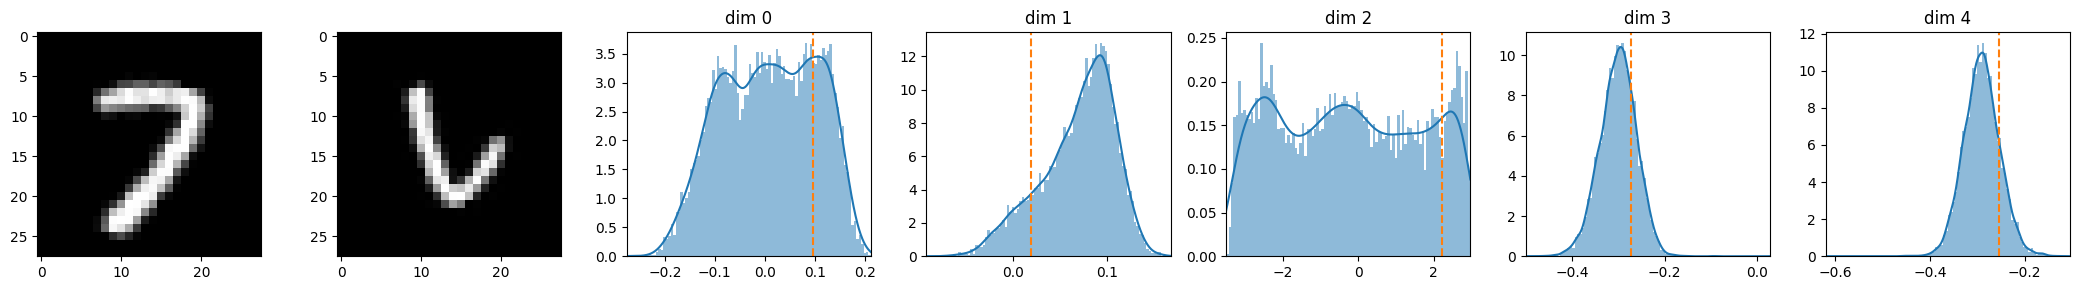

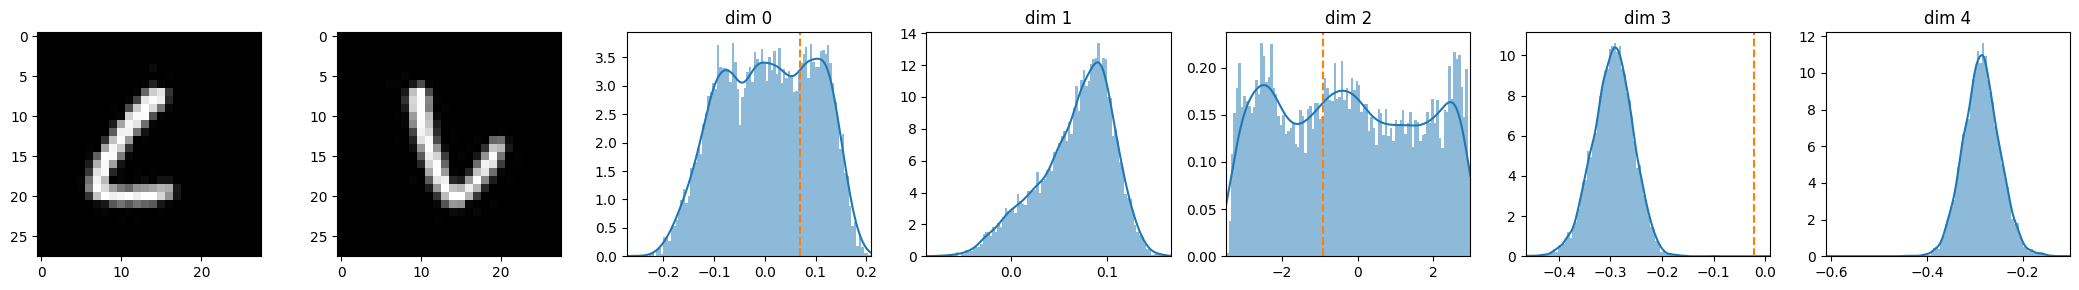

In [20]:
full_mask = jnp.array([1, 1, 1, 1, 1])
rot_mask = jnp.array([0, 0, 1, 0, 0])
transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
    x_,
    jnp.concatenate((
        jnp.linspace(-jnp.array(pgm_config.augment_bounds) * rot_mask, jnp.array(pgm_config.augment_bounds) * rot_mask, 4)[:3],
        jnp.linspace(-jnp.array(pgm_config.augment_bounds) * full_mask, jnp.array(pgm_config.augment_bounds) * full_mask, 3),
    ))
)

for x in transformed_xs:
    plot_gen_dists(x, prototype_function, rng, gen_model, gen_final_state.params, pgm_config)

[]

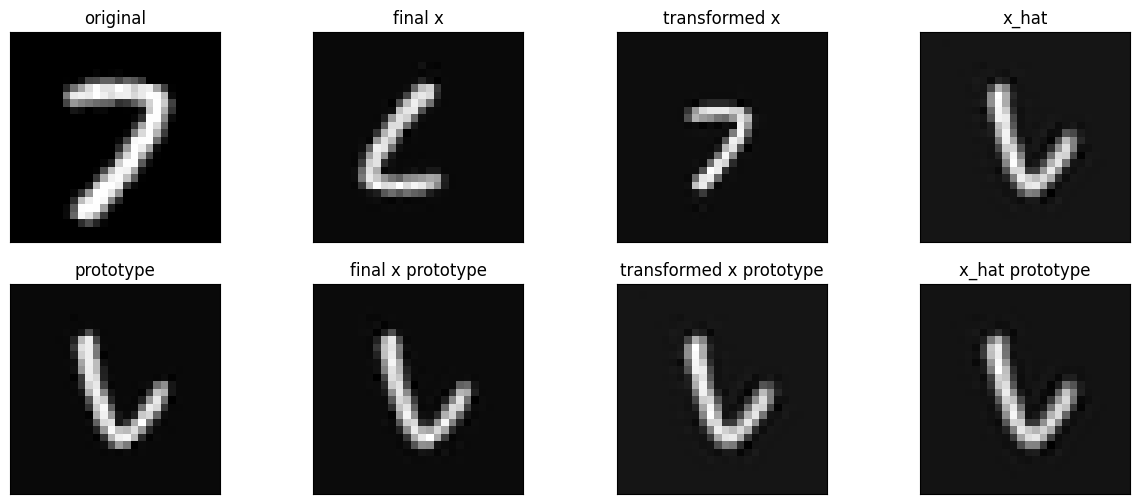

In [21]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, jnp.array(pgm_config.augment_bounds))
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])

## Train AUG-VAE

In [22]:
train_ds, val_ds, _ = get_data(vae_config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, dro

In [23]:
# load the final pgm state
# final_pgm_state_loaded = checkpoints.restore_checkpoint("pgm_model", pgm_state)

In [24]:
aug_vae_model = AUG_VAE(
    vae=vae_config.model.to_dict(),
    inference=pgm_config.model.inference.to_dict(),
    generative=pgm_config.model.generative.to_dict(),
    interpolation_order=pgm_config.interpolation_order,
)

aug_vae_state = create_aug_vae_state(aug_vae_model, vae_init_rng, vae_config, proto_final_state, gen_final_state)

INFO:absl:
+-----------------------------------------------------------------+------------------+---------+-----------+----------+
| Name                                                            | Shape            | Size    | Mean      | Std      |
+-----------------------------------------------------------------+------------------+---------+-----------+----------+
| params/generative_model/ConditionedConditioner_0/Dense_0/bias   | (256,)           | 256     | 0.0       | 0.0      |
| params/generative_model/ConditionedConditioner_0/Dense_0/kernel | (261, 256)       | 66,816  | 0.00039   | 0.0621   |
| params/generative_model/ConditionedConditioner_0/Dense_1/bias   | (256,)           | 256     | 0.0       | 0.0      |
| params/generative_model/ConditionedConditioner_0/Dense_1/kernel | (256, 256)       | 65,536  | -0.00012  | 0.0628   |
| params/generative_model/ConditionedConditioner_0/Dense_2/bias   | (65,)            | 65      | 0.0       | 0.0      |
| params/generative_model/Con

In [25]:
train_step, eval_step = make_aug_vae_train_and_eval(aug_vae_model, vae_config)
x = next(deterministic_data.start_input_pipeline(val_ds))['image'][0]
reconstruction_plot, sampling_plot = make_aug_vae_plotting_fns(vae_config, aug_vae_model, x)

2023-11-20 10:13:34.211441: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
run = wandb.init(
    project="iclr2024experiments",
    entity="invariance-learners",
    config=vae_config.to_dict(),
    mode="online",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

    0/10000 [..............................] - ETA: 0s - elbo: -1147.6257 - iwlb: nan - kld: 0.0000e+00 - ll: -1147.6257 - loss: 1147.6257 - elbo_test: -943.7736 - iwlb_test: nan - kld_test: 0.0123 - ll_test: -943.6505 - loss_test: 943.7736

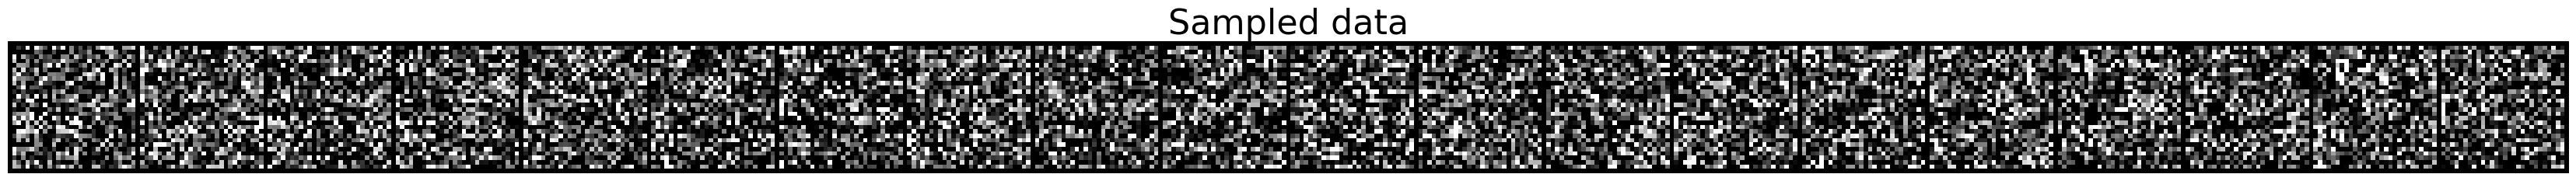

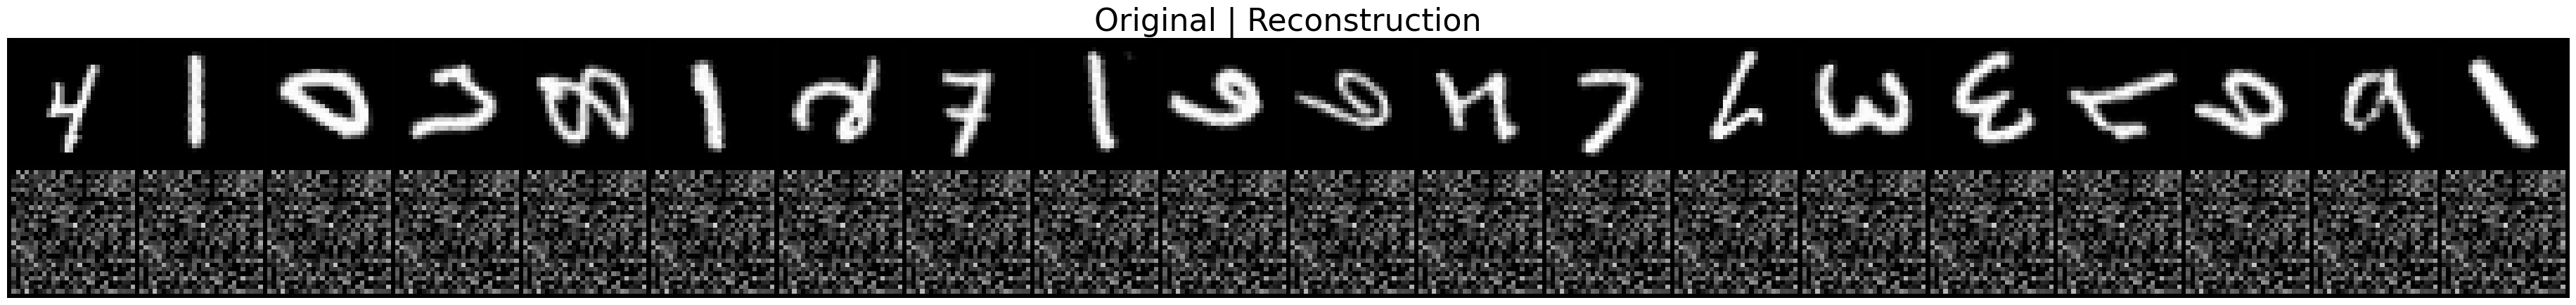

 1000/10000 [==>...........................] - ETA: 11:48 - elbo: -604.0963 - iwlb: nan - kld: 2.1798 - ll: -582.7332 - loss: 604.0963 - elbo_test: -590.6330 - iwlb_test: nan - kld_test: 2.2943 - ll_test: -568.1950 - loss_test: 590.633036 ETA: 2:55:04 - elbo: -869.1070 - iwlb: nan - kld: 0.0139 - ll: -868.9678 - loss: 869.1070 - elbo_test: -943.7736 - iwlb_test: nan - kld_test: 0.0123 - ll_test: -943.6505 - loss_test: 943.77 - ETA: 2:43:20 - elbo: -866.2887 - iwlb: nan - kld: 0.0134 - ll: -866.1550 - loss: 866.2887 - elbo_test: -943.7736 - iwlb_test: nan - kld_test: 0.0123 - ll_test: -943.6505 - loss_test: 943. - ETA: 2:24:12 - elbo: -861.3720 - iwlb: nan - kld: 0.0125 - ll: -861.2474 - loss: 861.3720 - elbo_test: -943.7736 - iwlb_test: nan - kld_test: 0.0123 - ll_test: -943.6505 - loss_test: 943.77 - ETA: 2:16:17 - elbo: -859.1436 - iwlb: nan - kld: 0.0121 - ll: -859.0229 - loss: 859.1436 - elbo_test: -943.7736 - iwlb_test: nan - kld_test: 0.0123 - ll_test: -943.6505 - loss_test: 943.

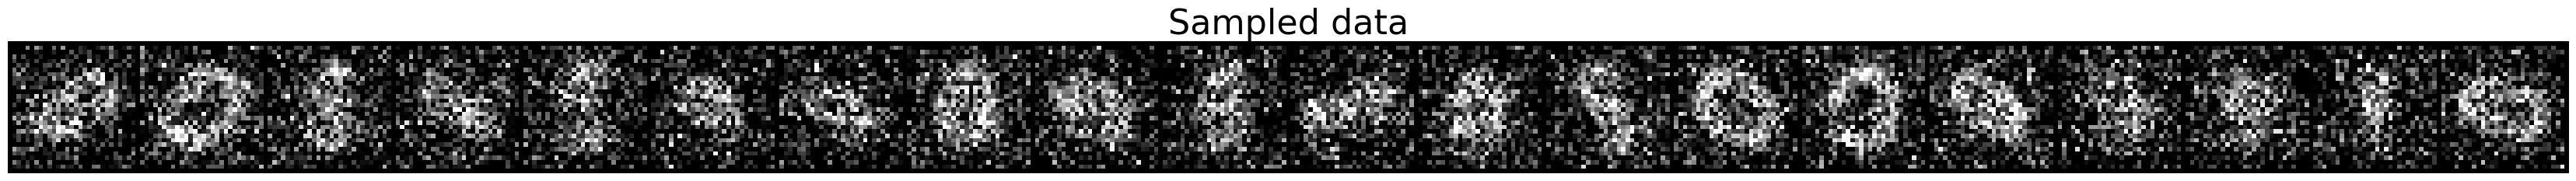

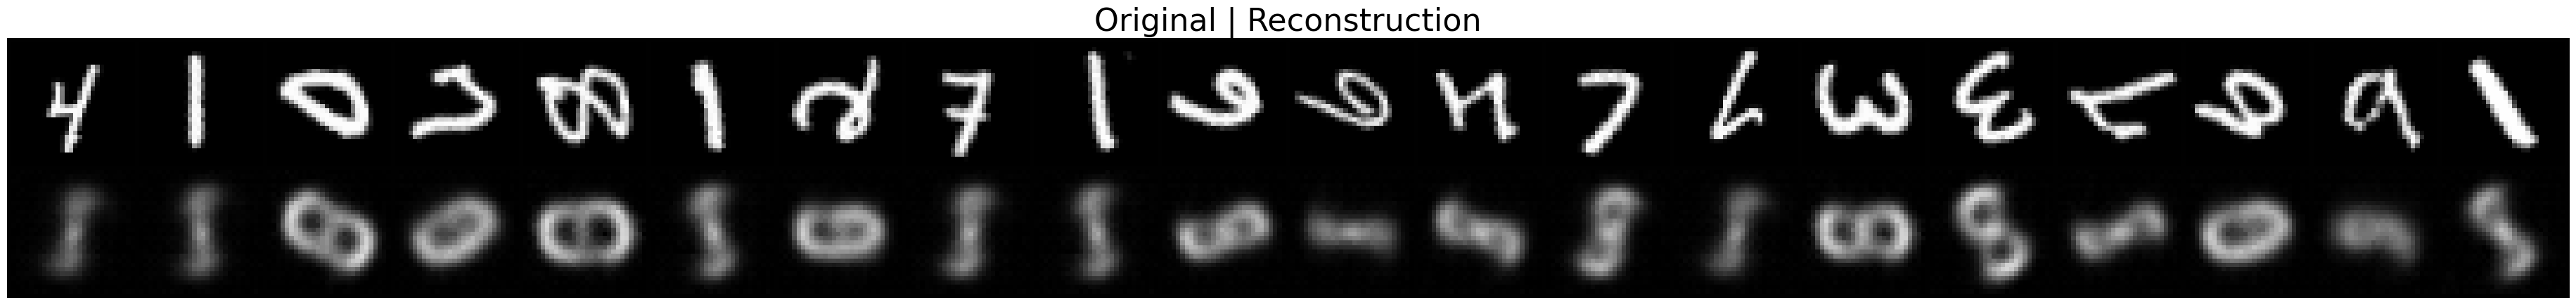

 2000/10000 [=====>........................] - ETA: 8:55 - elbo: -241.3814 - iwlb: nan - kld: 10.8170 - ll: -142.0681 - loss: 241.3814 - elbo_test: -218.0446 - iwlb_test: nan - kld_test: 11.2718 - ll_test: -115.0136 - loss_test: 218.0446ETA: 11:48 - elbo: -575.4637 - iwlb: nan - kld: 2.5566 - ll: -550.5034 - loss: 575.4637 - elbo_test: -590.6330 - iwlb_test: nan - kld_test: 2.2943 - ll_test: -568.1950 - loss_test: 59 - ETA: 11:45 - elbo: -574.5002 - iwlb: nan - kld: 2.5813 - ll: -549.3028 - loss: 574.5002 - elbo_test: -590.6330 - iwlb_test: nan - kld_test: 2.2943 - ll_test: -568.1950 - loss_test: 59 - ETA: 11:43 - elbo: -573.3966 - iwlb: nan - kld: 2.5970 - ll: -548.0497 - loss: 573.3966 - elbo_test: -590.6330 - iwlb_test: nan - kld_test: 2.2943 - ll_test: -568.1950 - loss_test: 590.63 - ETA: 11:42 - elbo: -573.0311 - iwlb: nan - kld: 2.6040 - ll: -547.6168 - loss: 573.0311 - elbo_test: -590.6330 - iwlb_test: nan - kld_test: 2.2943 - ll_test: -568.1950 - loss_test: 590. - ETA: 11:40 - 

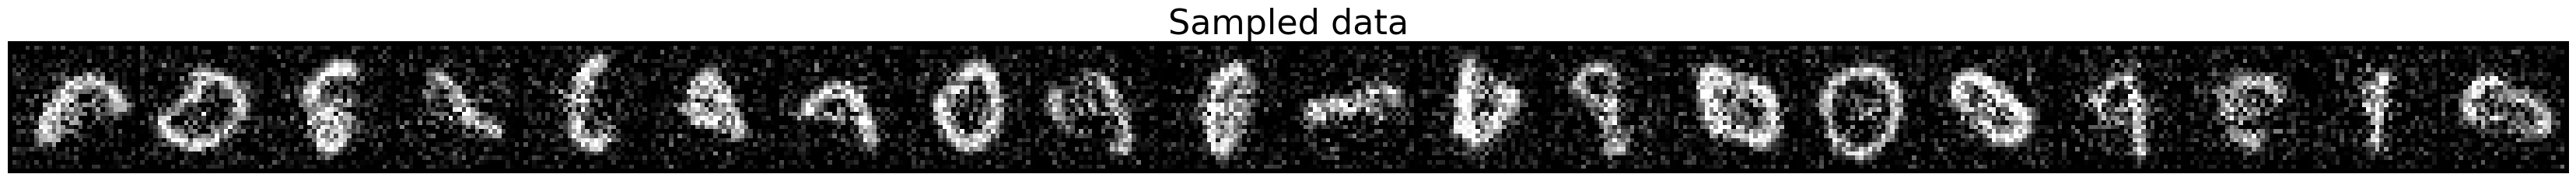

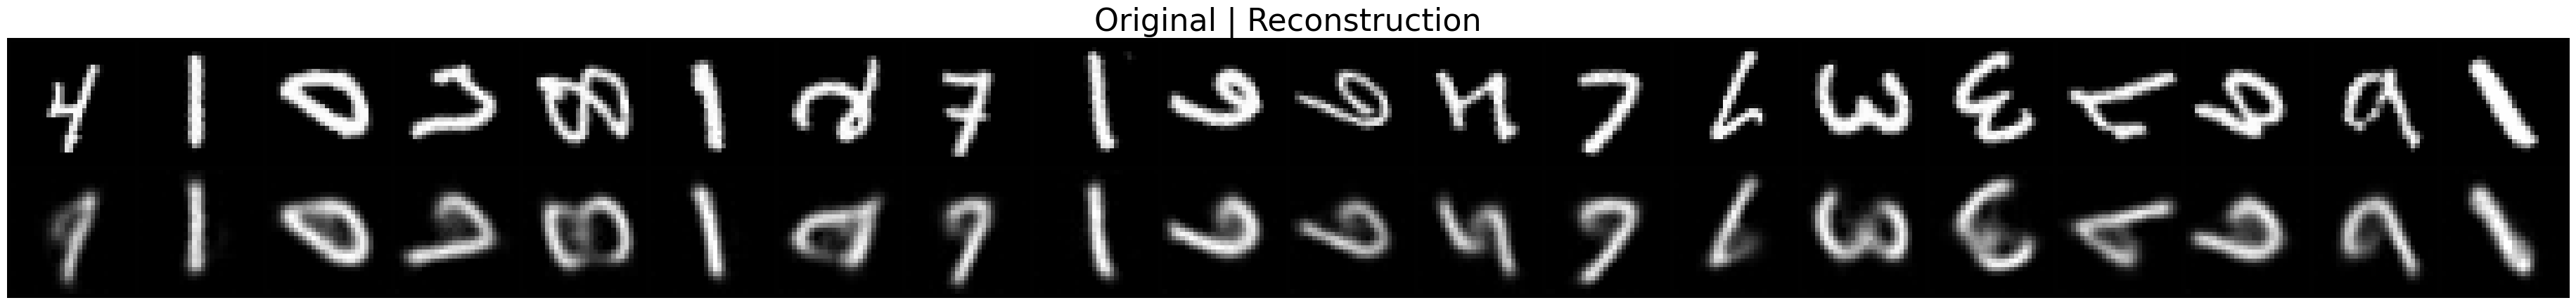

 3000/10000 [========>.....................] - ETA: 7:19 - elbo: 116.0030 - iwlb: nan - kld: 19.5122 - ll: 276.0430 - loss: -116.0030 - elbo_test: 130.2198 - iwlb_test: nan - kld_test: 19.6994 - ll_test: 290.6719 - loss_test: -130.2198 6- ETA: 8:58 - elbo: -219.1075 - iwlb: nan - kld: 11.4581 - ll: -114.4886 - loss: 219.1075 - elbo_test: -218.0446 - iwlb_test: nan - kld_test: 11.2718 - ll_test: -115.0136 - loss_test: 218.044 - ETA: 8:58 - elbo: -218.4471 - iwlb: nan - kld: 11.4734 - ll: -113.6982 - loss: 218.4471 - elbo_test: -218.0446 - iwlb_test: nan - kld_test: 11.2718 - ll_test: -115.0136 - loss_test: 218.044 - ETA: 8:57 - elbo: -218.1950 - iwlb: nan - kld: 11.4926 - ll: -113.2806 - loss: 218.1950 - elbo_test: -218.0446 - iwlb_test: nan - kld_test: 11.2718 - ll_test: -115.0136 - loss_test: 218.04 - ETA: 8:56 - elbo: -217.0506 - iwlb: nan - kld: 11.5107 - ll: -111.9910 - loss: 217.0506 - elbo_test: -218.0446 - iwlb_test: nan - kld_test: 11.2718 - ll_test: -115.0136 - loss_test: 218.

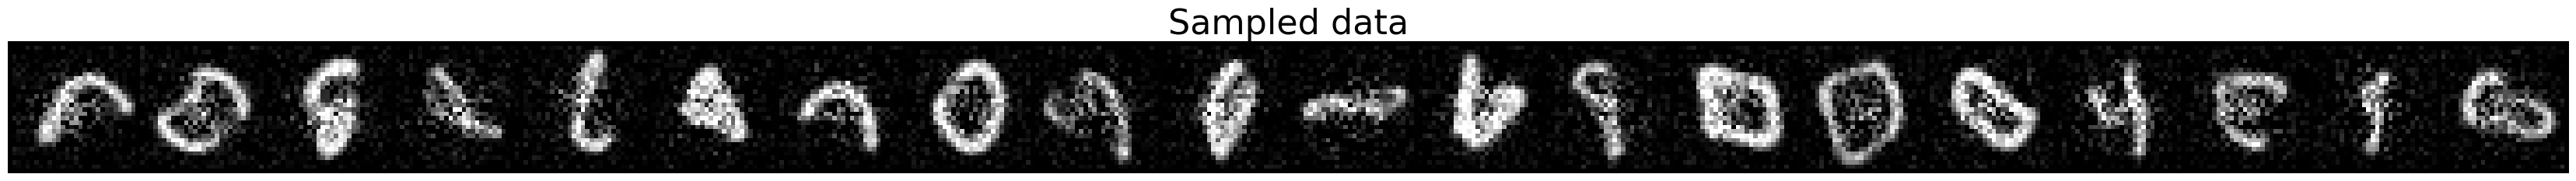

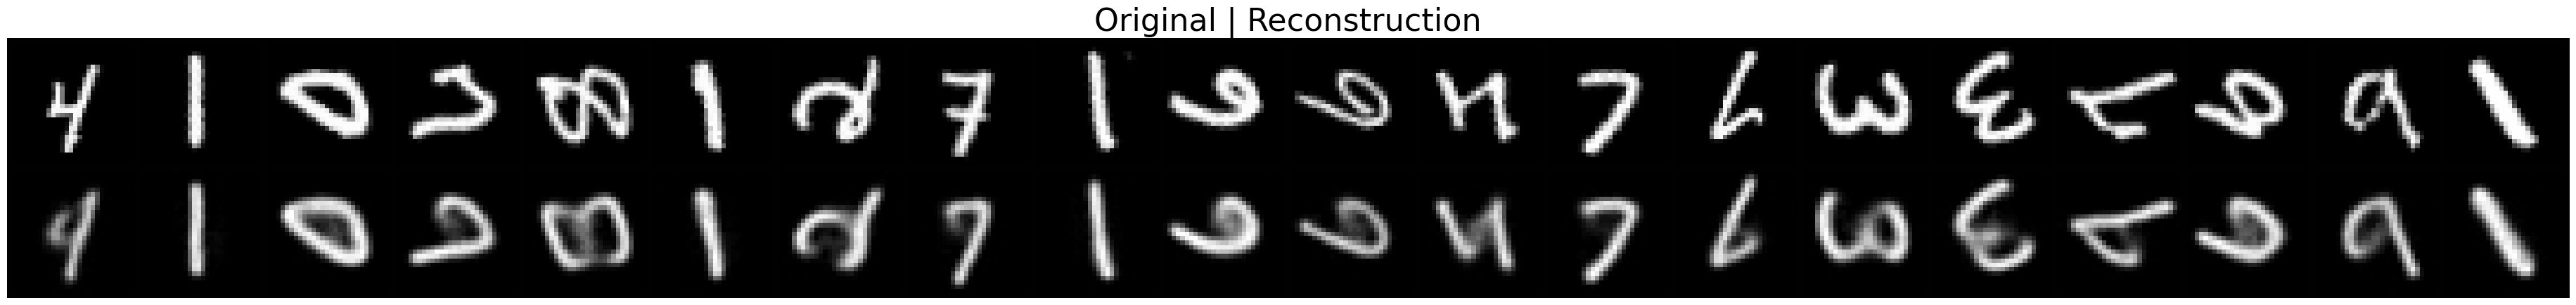

 4000/10000 [===========>..................] - ETA: 6:04 - elbo: 386.5629 - iwlb: nan - kld: 24.5729 - ll: 557.5414 - loss: -386.5629 - elbo_test: 402.1352 - iwlb_test: nan - kld_test: 24.6554 - ll_test: 572.0249 - loss_test: -402.1352- ETA: 7:18 - elbo: 142.1472 - iwlb: nan - kld: 20.0650 - ll: 304.8587 - loss: -142.1472 - elbo_test: 130.2198 - iwlb_test: nan - kld_test: 19.6994 - ll_test: 290.6719 - loss_test: -130.219 - ETA: 7:17 - elbo: 142.1491 - iwlb: nan - kld: 20.0769 - ll: 304.9336 - loss: -142.1491 - elbo_test: 130.2198 - iwlb_test: nan - kld_test: 19.6994  - ETA: 7:09 - elbo: 168.5559 - iwlb: nan - kld: 20.6063 - ll: 333.4297 - loss: -168.5559 - elbo_test: 164.2099 - iwlb_test: nan - kld_test: 20.0207 - ll_test: 324.9637 - loss_test: -164.209 - ETA: 7:09 - elbo: 168.6337 - iwlb: nan - kld: 20.6261 - ll: 333.6409 - loss: -168.6337 - elbo_test: 164.2099 - iwlb_test: nan - kld_test: 20.0207 - ll_test: 324.9637 - loss_test: -16 - ETA: 7:07 - elbo: 170.1069 - iwlb: nan - kld: 20.

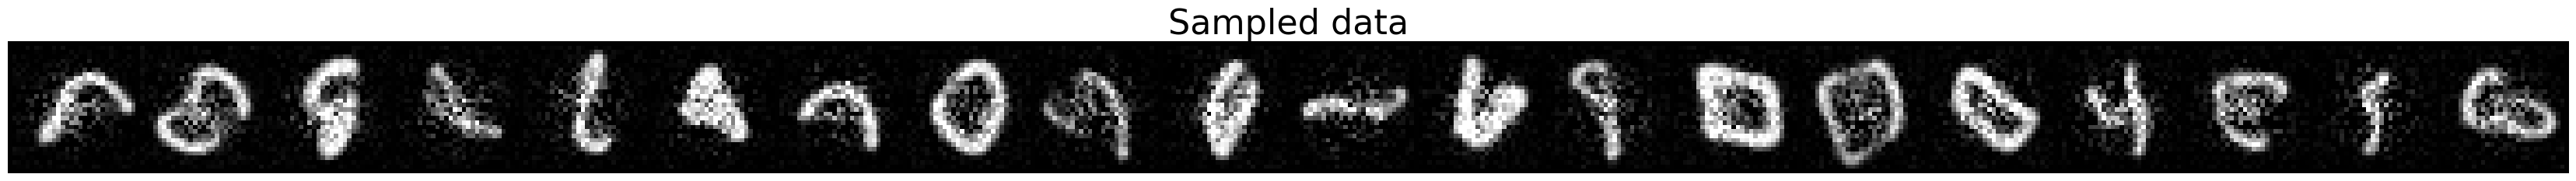

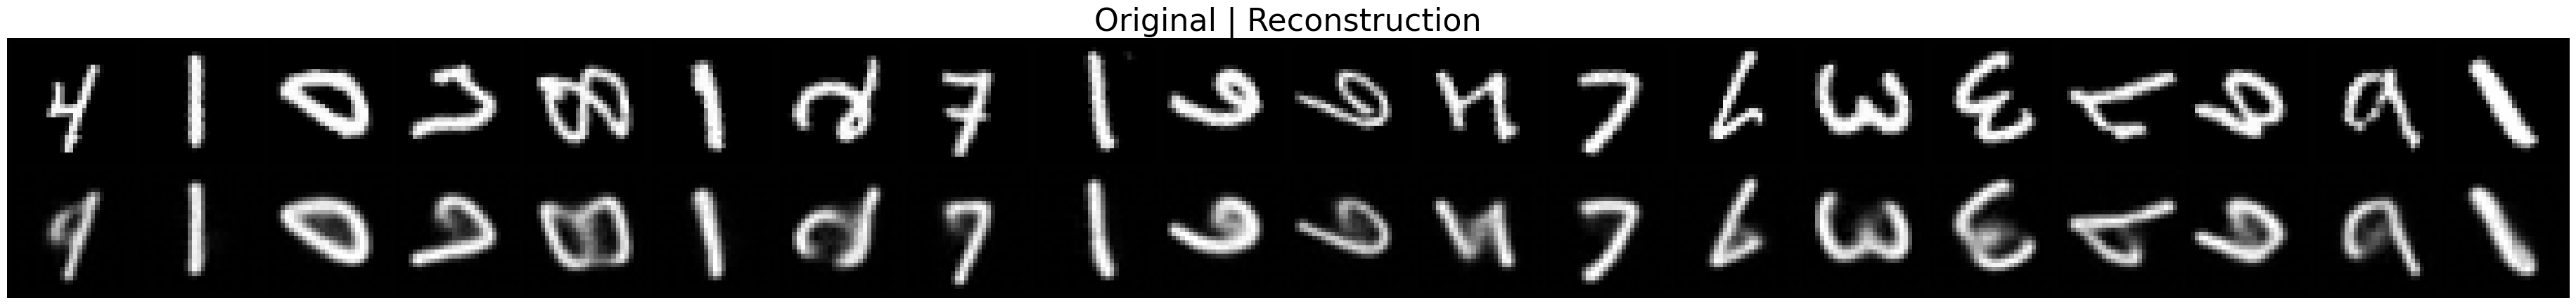

 5000/10000 [==============>...............] - ETA: 4:56 - elbo: 566.5696 - iwlb: nan - kld: 28.3539 - ll: 724.5372 - loss: -566.5696 - elbo_test: 590.7650 - iwlb_test: nan - kld_test: 28.4118 - ll_test: 747.0297 - loss_test: -590.7650- ETA: 6:03 - elbo: 405.4331 - iwlb: nan - kld: 24.9011 - ll: 576.3439 - loss: -405.4331 - elbo_test: 402.1352 - iwlb_test: nan - kld_test: 24.6554 - ll_test: 572.0249 - loss_test: -402.135 - ETA: 6:02 - elbo: 405.3746 - iwlb: nan - kld: 24.9032 - ll: 576.2659 - loss: -405.3746 - elbo_test: 402.1352 - iwlb_test: nan - kld_test: 24.6554 - ll_test: 572.0249 - loss_test: -402.13 - ETA: 6:02 - elbo: 404.6386 - iwlb: nan - kld: 24.9054 - ll: 575.4780 - loss: -404.6386 - elbo_test: 402.1352 - iwlb_test: nan - kld_test: 24.6554 - ll_test: 572.0249 - loss_test: -402.135 - ETA: 6:02 - elbo: 405.4268 - iwlb: nan - kld: 24.9004 - ll: 576.1983 - loss: -405.4268 - elbo_test: 402.1352 - iwlb_test: nan - kld_test: 24.6554 - ll_test: 572.0249 - loss_test: -402.13 - ETA: 

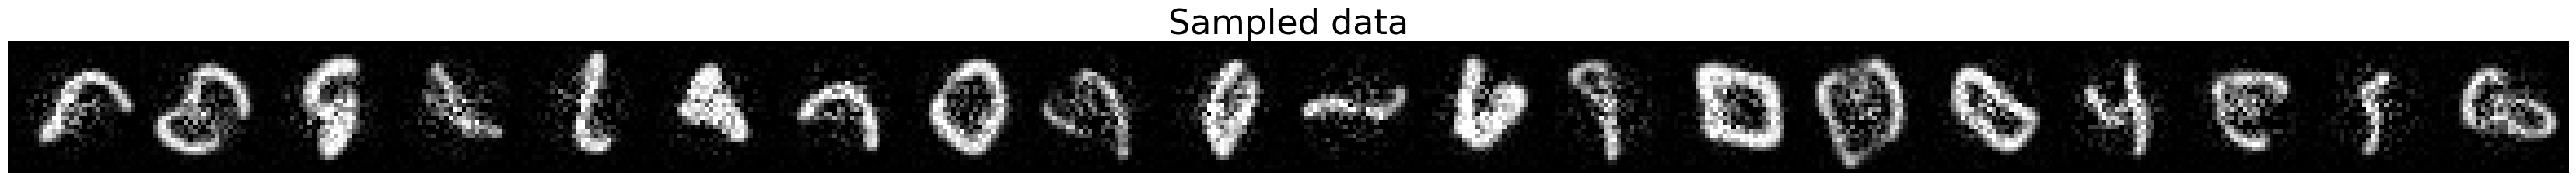

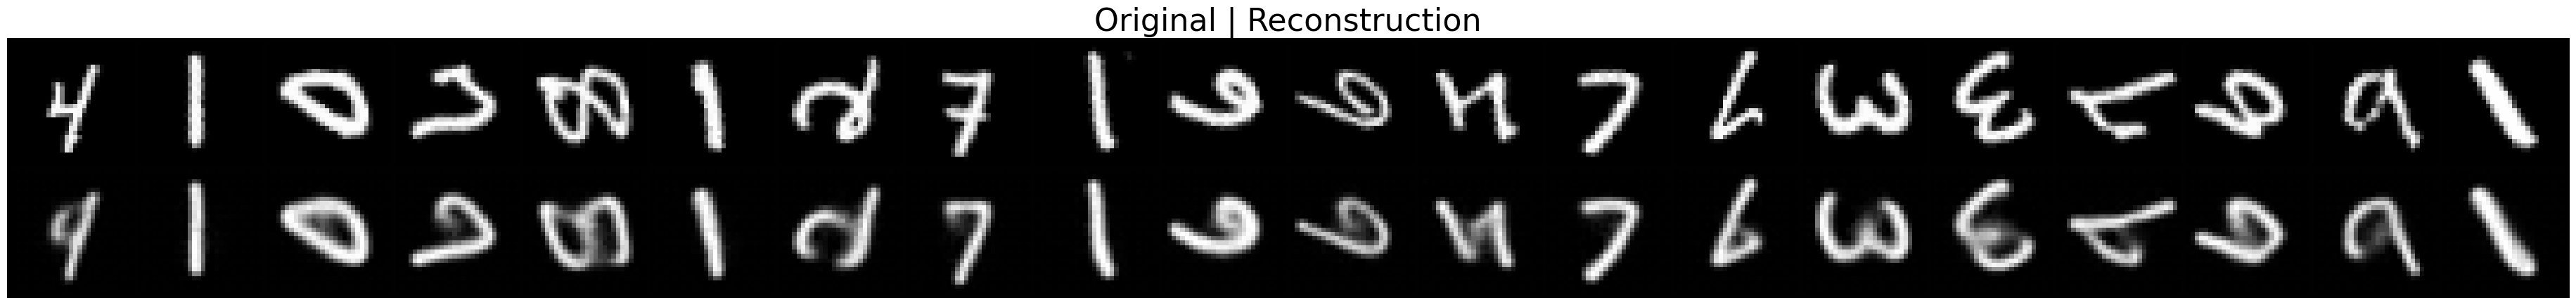

 6000/10000 [=================>............] - ETA: 3:54 - elbo: 667.5304 - iwlb: nan - kld: 31.7076 - ll: 799.9863 - loss: -667.5304 - elbo_test: 711.7903 - iwlb_test: nan - kld_test: 31.8867 - ll_test: 842.8260 - loss_test: -711.7903- ETA: 4:55 - elbo: 577.6785 - iwlb: nan - kld: 28.6315 - ll: 734.3812 - loss: -577.6785 - elbo_test: 590.7650 - iwlb_test: nan - kld_test: 28.4118 - ll_test: 747.0297 - loss_test: -59 - ETA: 4:55 - elbo: 573.2047 - iwlb: nan - kld: 28.6765 - ll: 729.9298 - loss: -573.2047 - elbo_test: 590.7650 - iwlb_test: nan - kld_test: 28.4118 - ll_test: 747.0297 - loss_test: -590.7 - ETA: 4:54 - elbo: 570.5417 - iwlb: nan - kld: 28.6628 - ll: 727.0715 - loss: -570.5417 - elbo_test: 590.7650 - iwlb_test: nan - kld_test: 28.4118 - ll_test: 747.0297 - loss_test: -590.7 - ETA: 4:54 - elbo: 566.4001 - iwlb: nan - kld: 28.6751 - ll: 722.8750 - loss: -566.4001 - elbo_test: 590.7650 - iwlb_test: nan - kld_test: 28.4118 - ll_test: 747.0297 - loss_test: -590.7 - ETA: 4:53 - el

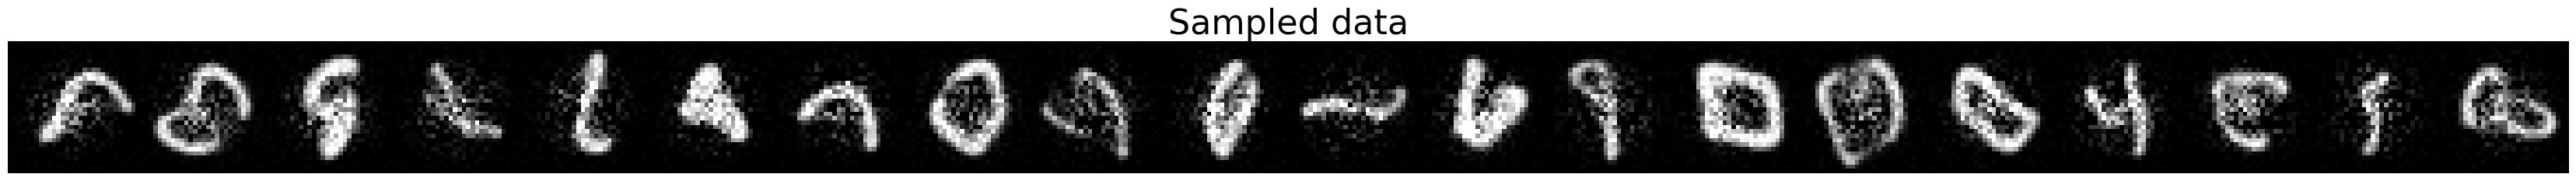

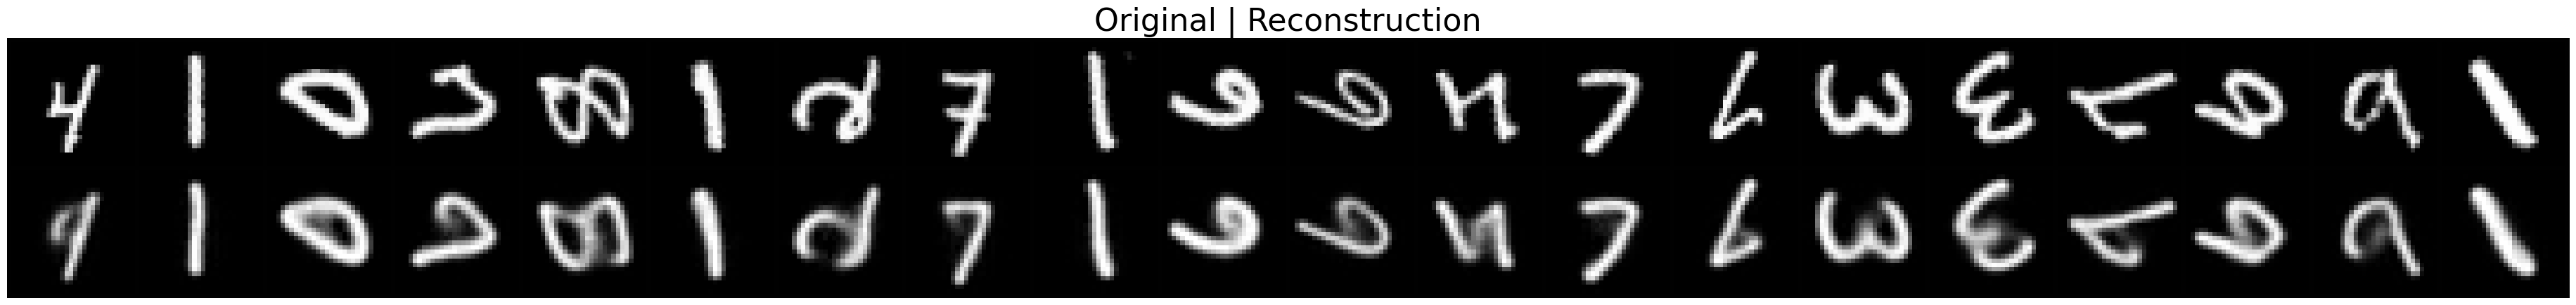

 7000/10000 [====================>.........] - ETA: 2:53 - elbo: 741.4172 - iwlb: nan - kld: 35.4006 - ll: 844.5410 - loss: -741.4172 - elbo_test: 781.8140 - iwlb_test: nan - kld_test: 35.2620 - ll_test: 882.4858 - loss_test: -781.8140- ETA: 3:54 - elbo: 678.4891 - iwlb: nan - kld: 31.9165 - ll: 809.2404 - loss: -678.4891 - elbo_test: 711.7903 - iwlb_test: nan - kld_test: 31.8867 - ll_test: 842.8260 - loss_test: -711.7 - ETA: 3:54 - elbo: 679.1903 - iwlb: nan - kld: 31.9722 - ll: 810.0400 - loss: -679.1903 - elbo_test: 711.7903 - iwlb_test: nan - kld_test: 31.8867 - ll_test: 842.8260 - loss_test: -711.7 - ETA: 3:53 - elbo: 679.8565 - iwlb: nan - kld: 31.9984 - ll: 810.6845 - loss: -679.8565 - elbo_test: 711.7903 - iwlb_test: nan - kld_test: 31.8867 - ll_test: 842.8260 - loss_test: -711.7 - ETA: 3:53 - elbo: 681.5716 - iwlb: nan - kld: 32.0125 - ll: 812.3281 - loss: -681.5716 - elbo_test: 711.7903 - iwlb_test: nan - kld_test: 31.8867 - ll_test: 842.8260 - loss_test: -711.7 - ETA: 3:52 -

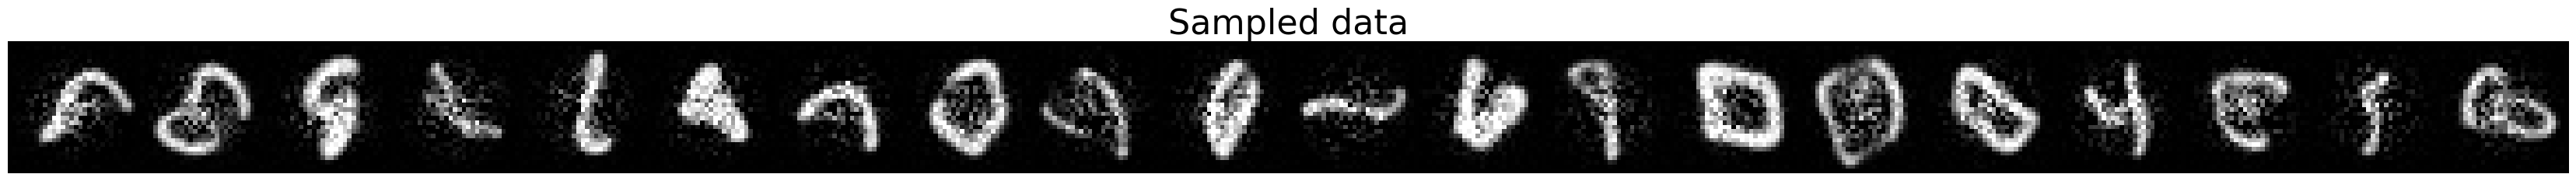

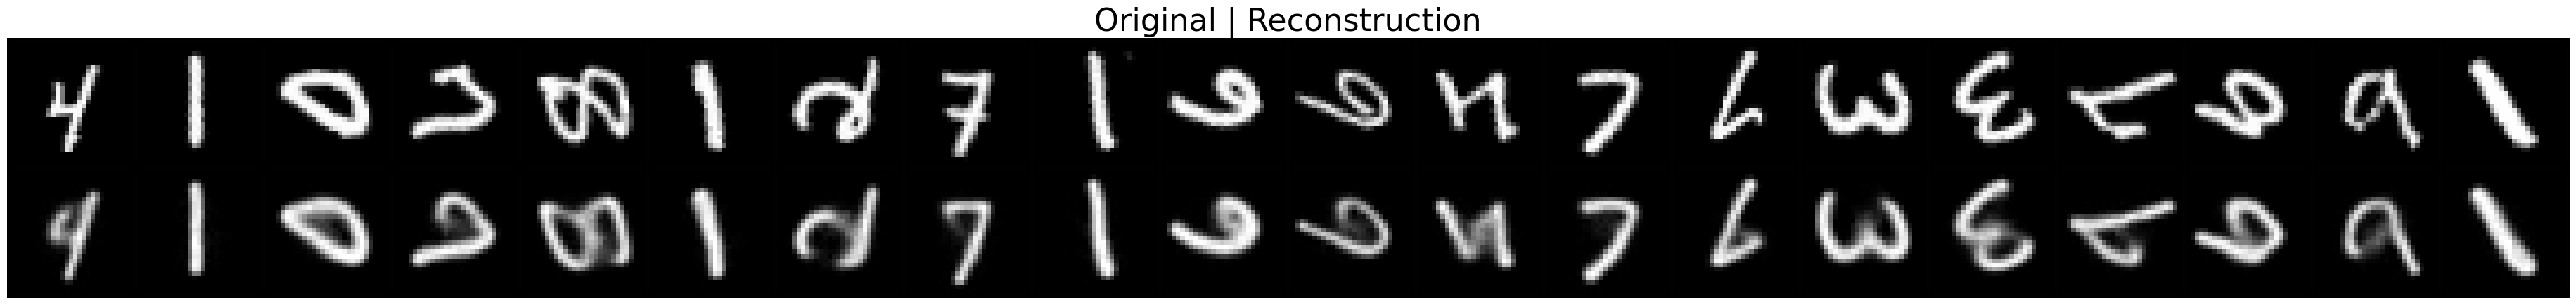

 8000/10000 [=======================>......] - ETA: 1:54 - elbo: 810.9127 - iwlb: nan - kld: 39.7508 - ll: 886.5164 - loss: -810.9127 - elbo_test: 851.6414 - iwlb_test: nan - kld_test: 39.7254 - ll_test: 925.5076 - loss_test: -851.6414- ETA: 2:52 - elbo: 741.2504 - iwlb: nan - kld: 35.5585 - ll: 842.1186 - loss: -741.2504 - elbo_test: 781.8140 - iwlb_test: nan - kld_test: 35.2620 - ll_test: 882.4858 - loss_test: -781.8 - ETA: 2:51 - elbo: 740.7711 - iwlb: nan - kld: 35.5586 - ll: 841.5184 - loss: -740.7711 - elbo_test: 781.8140 - iwlb_test: nan - kld_test: 35.2620 - ll_test: 882.4858 - loss_test: -781.8 - ETA: 2:51 - elbo: 743.8359 - iwlb: nan - kld: 35.5657 - ll: 844.4821 - loss: -743.8359 - elbo_test: 781.8140 - iwlb_test: nan - kld_test: 35.2620 - ll_test: 882.4858 - loss_test: -781.8 - ETA: 2:51 - elbo: 747.1976 - iwlb: nan - kld: 35.5665 - ll: 847.7249 - loss: -747.1976 - elbo_test: 781.8140 - iwlb_test: nan - kld_test: 35.2620 - ll_test: 882.4858 - loss_test: -781.8 - ETA: 2:50 -

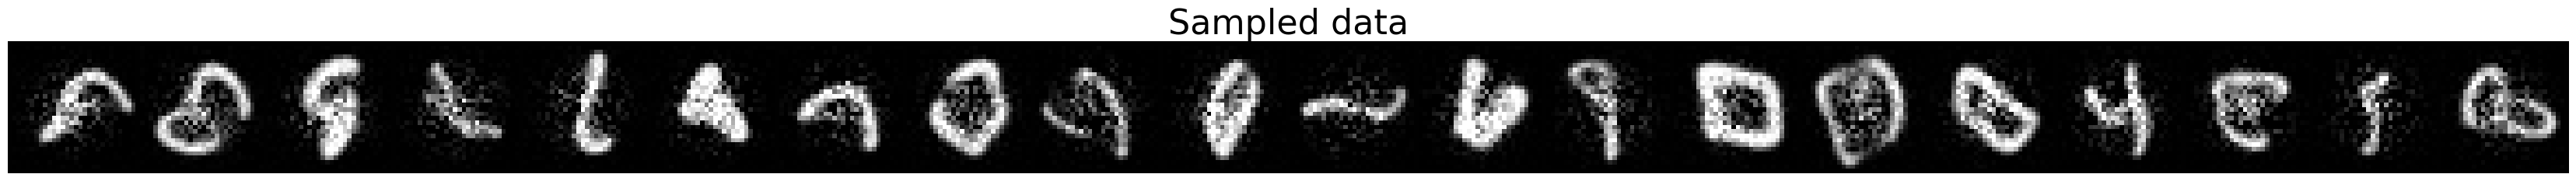

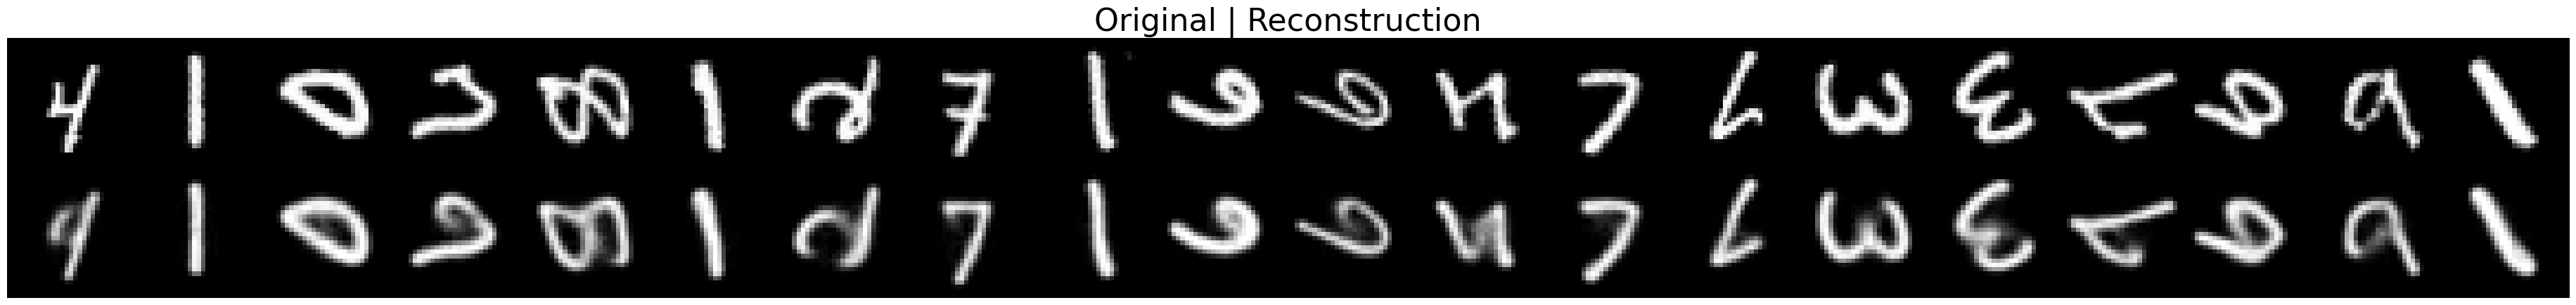

 9000/10000 [==========================>...] - ETA: 57s - elbo: 851.8542 - iwlb: nan - kld: 44.1736 - ll: 906.7626 - loss: -851.8542 - elbo_test: 899.5853 - iwlb_test: nan - kld_test: 44.0301 - ll_test: 953.3126 - loss_test: -899.5853 - ETA: 1:53 - elbo: 819.9651 - iwlb: nan - kld: 39.9363 - ll: 893.8262 - loss: -819.9651 - elbo_test: 851.6414 - iwlb_test: nan - kld_test: 39.7254 - ll_test: 925.5076 - loss_test: -851.641 - ETA: 1:53 - elbo: 817.9056 - iwlb: nan - kld: 39.9543 - ll: 891.7670 - loss: -817.9056 - elbo_test: 851.6414 - iwlb_test: nan - kld_test: 39.7254 - ll_test: 925.5076 - loss_test: -851.641 - ETA: 1:53 - elbo: 818.7548 - iwlb: nan - kld: 39.9699 - ll: 892.6120 - loss: -818.7548 - elbo_test: 851.6414 - iwlb_test: nan - kld_test: 39.7254 - ll_test: 925.5076 - loss_test: -851.641 - ETA: 1:53 - elbo: 818.0321 - iwlb: nan - kld: 39.9794 - ll: 891.8740 - loss: -818.0321 - elbo_test: 851.6414 - iwlb_test: nan - kld_test: 39.7254 - ll_test: 925.5076 - loss_test: -851.641 - ETA

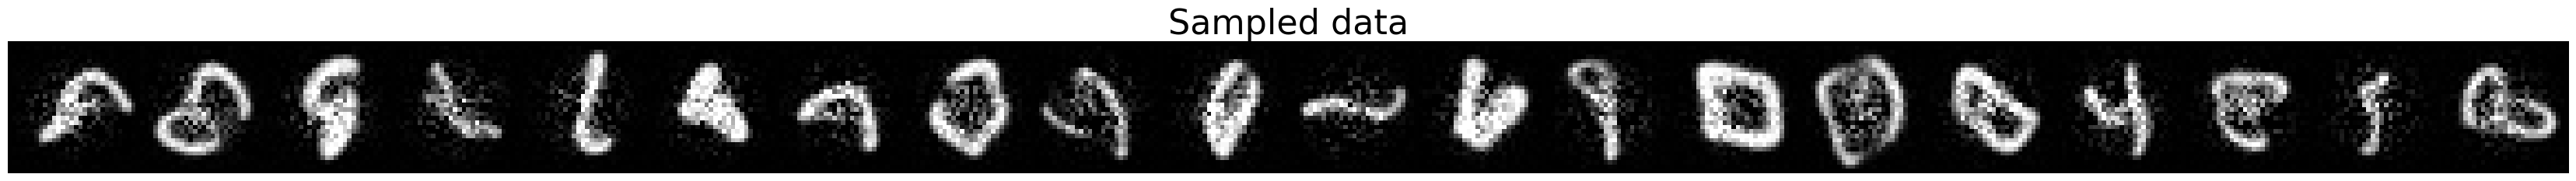

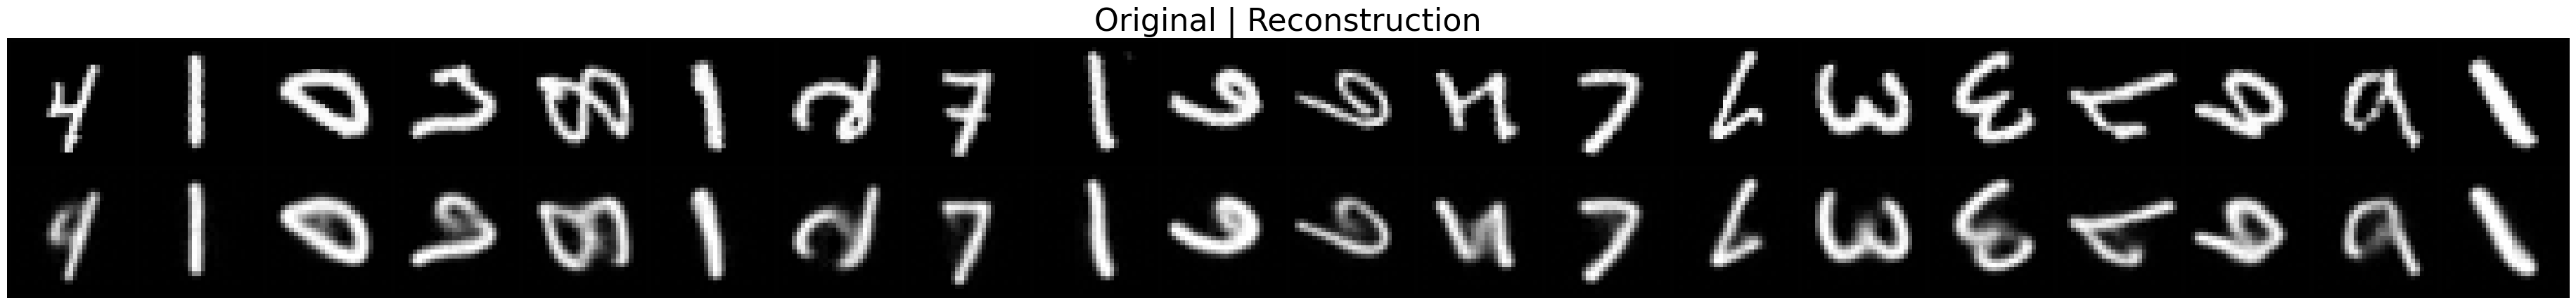

10000/10000 [==============================] - 568s 57ms/step - elbo: 876.8982 - iwlb: nan - kld: 46.5892 - ll: 923.5220 - loss: -876.8982 - elbo_test: 928.7297 - iwlb_test: nan - kld_test: 46.6017 - ll_test: 975.3317 - loss_test: -928.729755s - elbo: 864.1502 - iwlb: nan - kld: 44.4706 - ll: 918.1641 - loss: -864.1502 - elbo_test: 899.5853 - iwlb_test: nan - kld_test: 44.0301 - ll_test: 953.3126 - loss_test: -89 - ETA: 55s - elbo: 854.7762 - iwlb: nan - kld: 44.4913 - ll: 908.7581 - loss: -854.7762 - elbo_test: 899.5853 - iwlb_test: nan - kld_test: 44.0301 - ll_test: 953.3126 - loss_test: -89 - ETA: 55s - elbo: 853.2094 - iwlb: nan - kld: 44.4448 - ll: 907.0783 - loss: -853.2094 - elbo_test: 899.5853 - iwlb_test: nan - kld_test: 44.0301 - ll_test: 953.3126 - loss_test: -89 - ETA: 54s - elbo: 853.9274 - iwlb: nan - kld: 44.4527 - ll: 907.7493 - loss: -853.9274 - elbo_test: 899.5853 - iwlb_test: nan - kld_test: 44.0301 - ll_test: 953.3126 - loss_test: -89 - ETA: 54s - elbo: 856.6772 - i

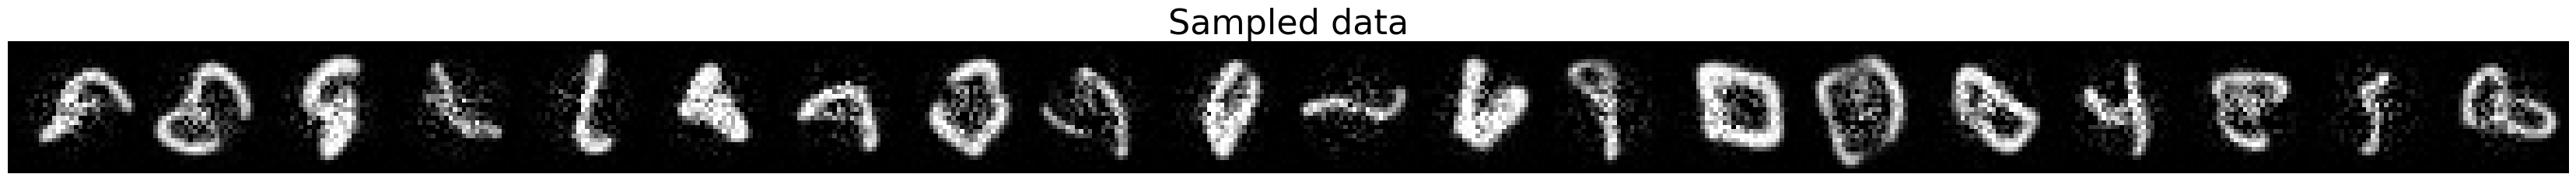

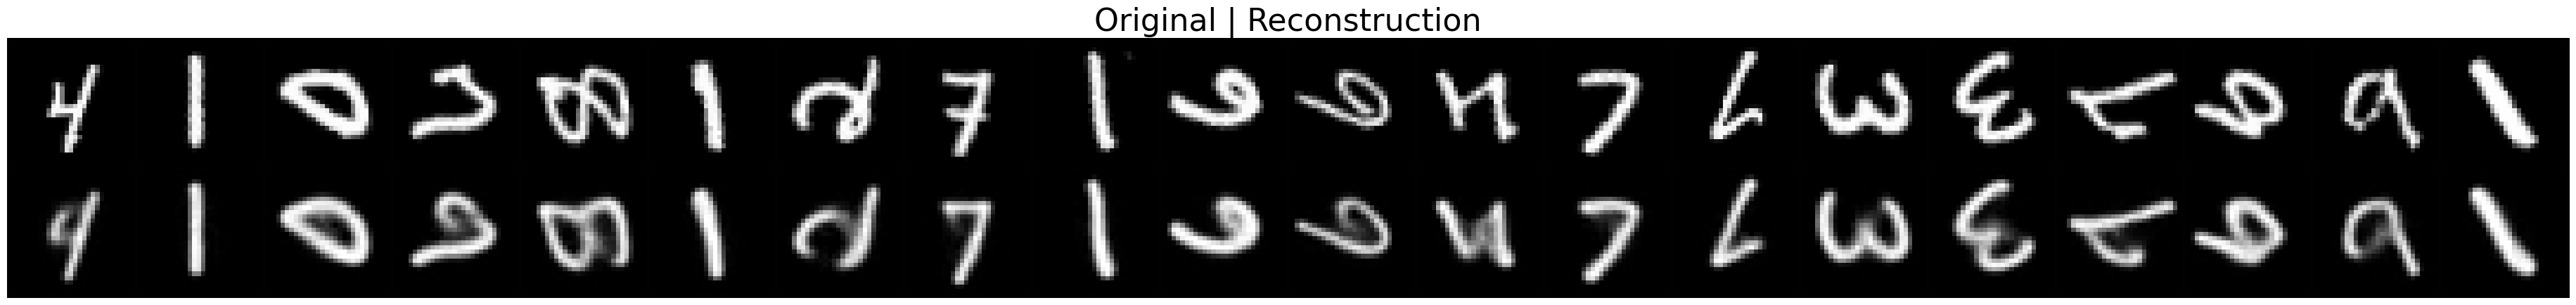

In [27]:
final_aug_vae_state, history, _ = ciclo.train_loop(
    aug_vae_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.every(int(vae_config.steps * vae_config.plot_freq)): [
            sampling_plot,
            reconstruction_plot,
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: [
            eval_step,
        ],
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(vae_config.steps * vae_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=vae_config.steps),
    ],
    stop=vae_config.steps + 1,
)

In [28]:
run.finish()

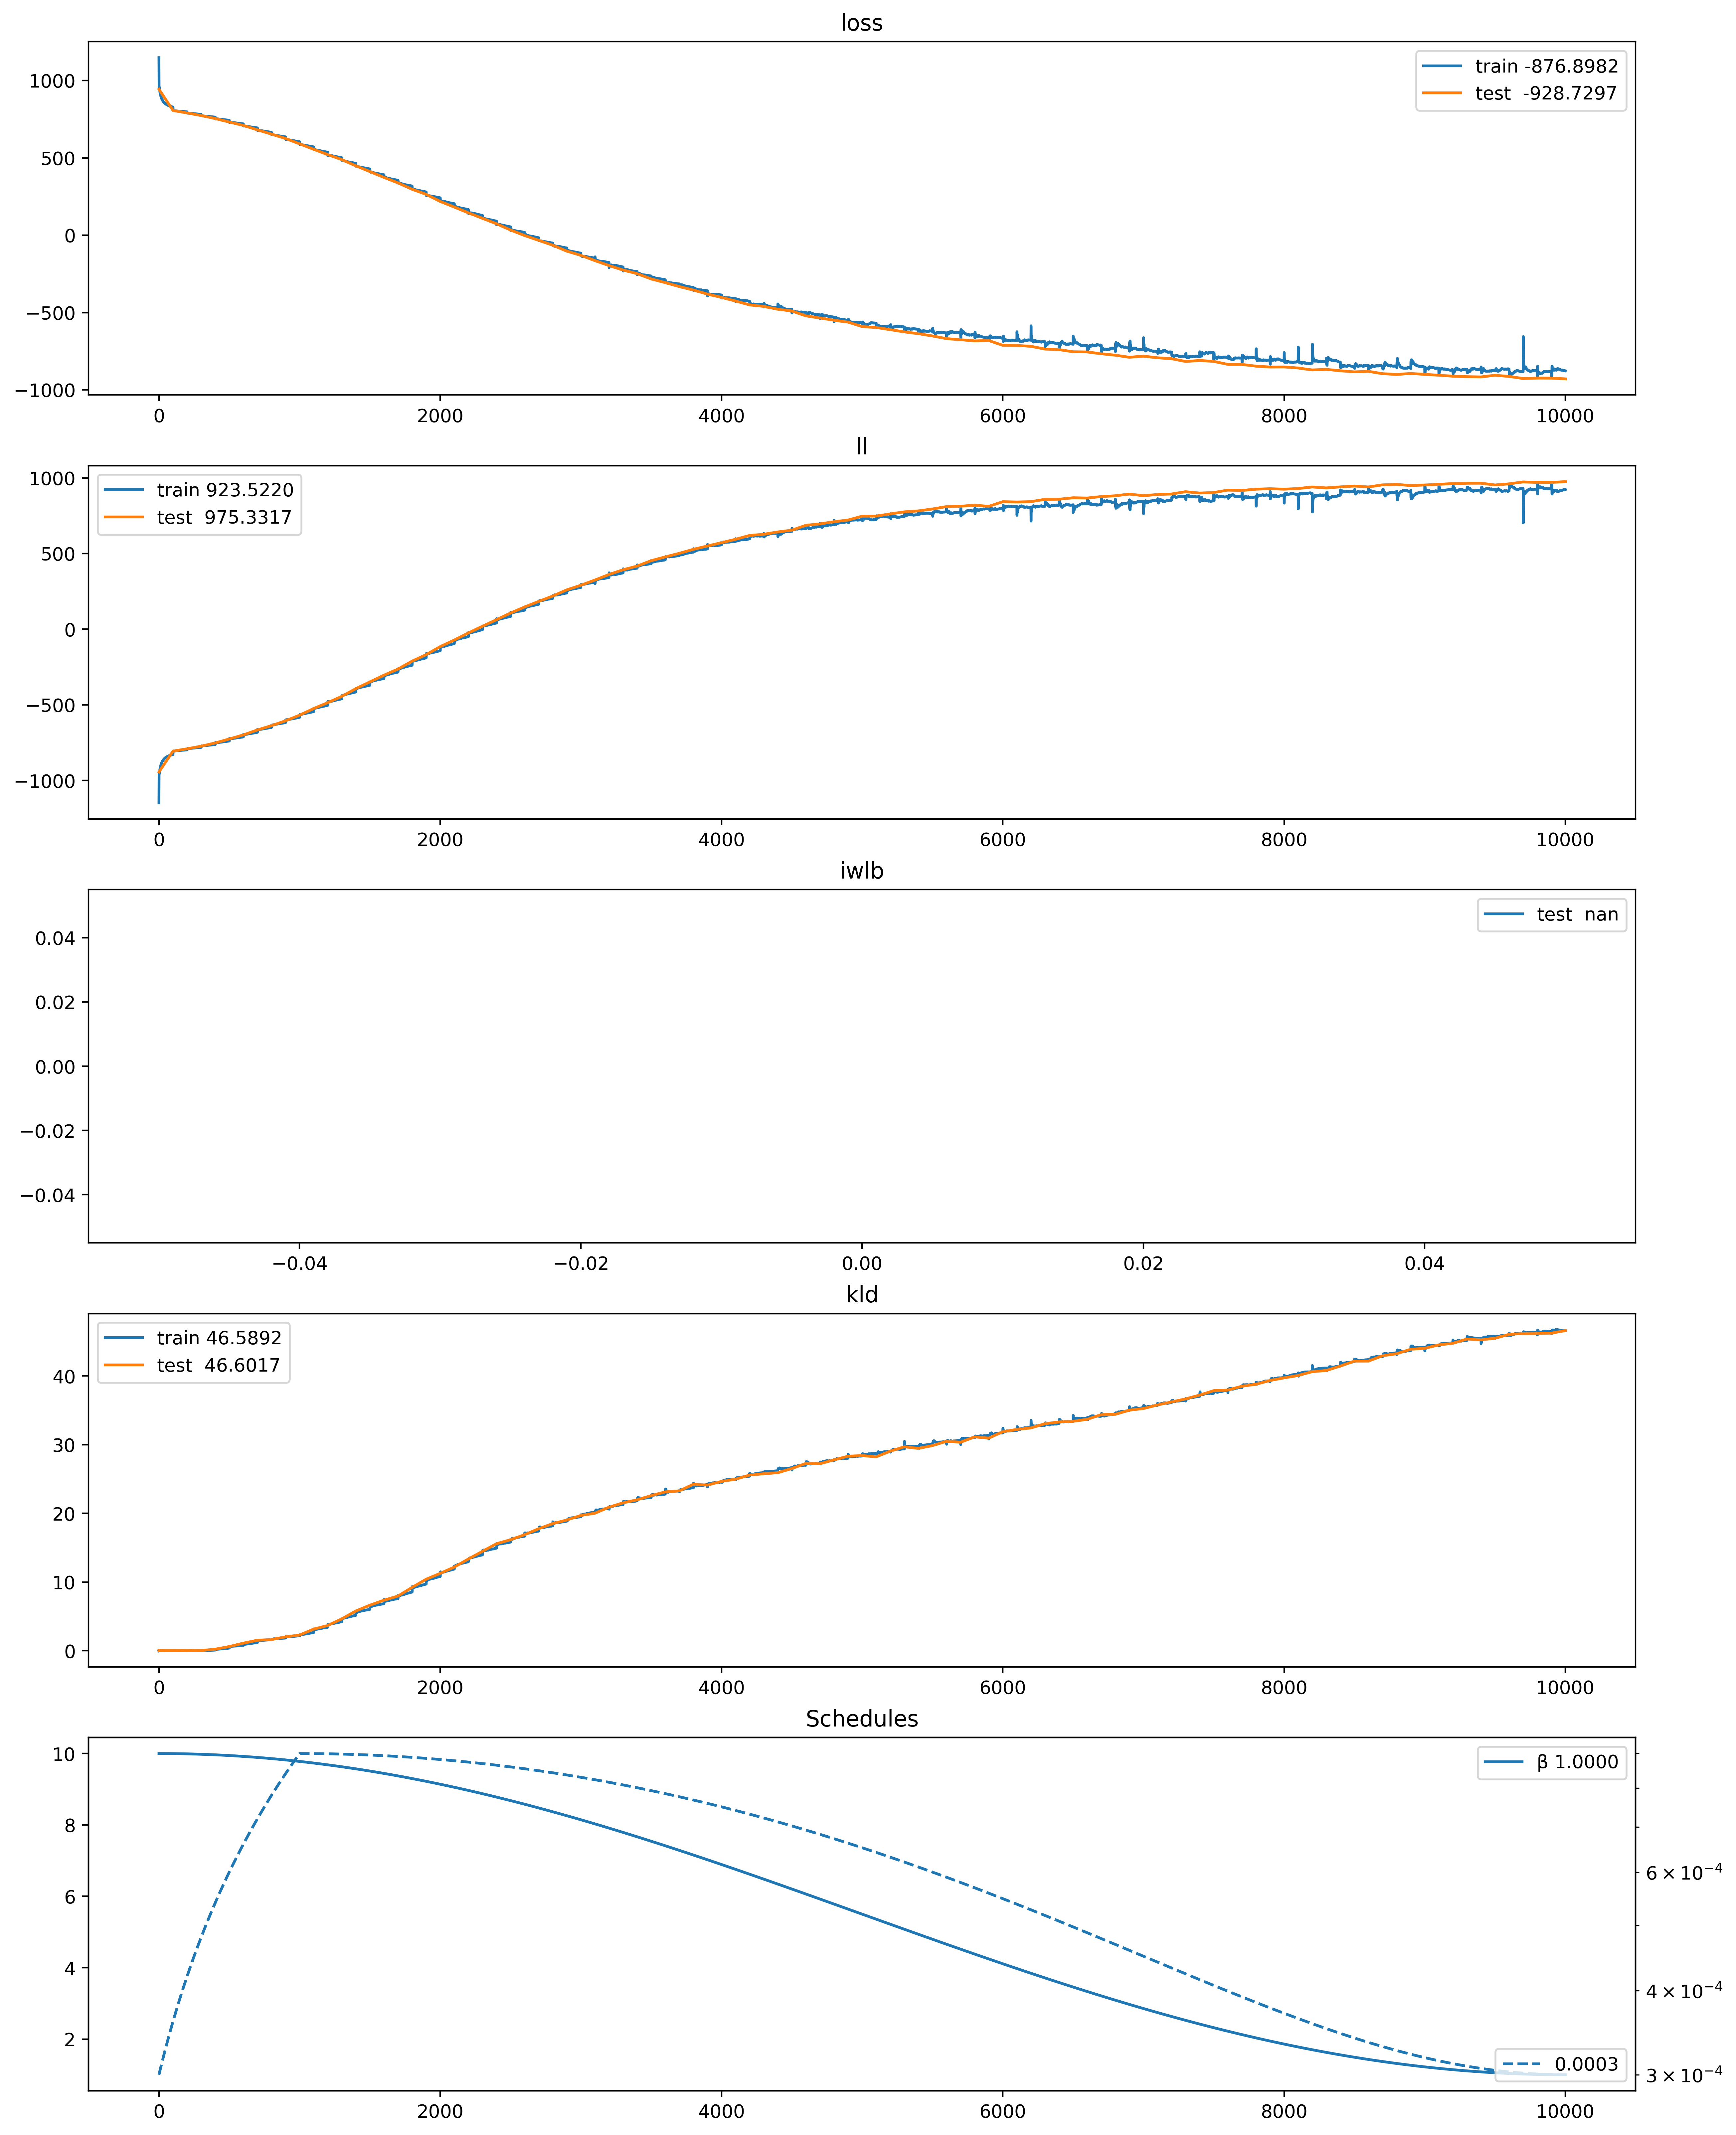

In [29]:
# plot the training history
steps, loss, elbo, ll, kld, lr, β = history.collect(
    "steps", "loss", "elbo", "ll", "kld", "lr", "β"
)
steps_test, loss_test, elbo_test, ll_test, kld_test, iwlb_test = history.collect(
    "steps", "loss_test", "elbo_test", "ll_test", "kld_test", "iwlb_test"
)

n_plots = 5
fig, axs = plt.subplots(n_plots, 1, figsize=(15, 4 * n_plots), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, ll, label=f"train {ll[-1]:.4f}")
axs[1].plot(steps_test, ll_test, label=f"test  {ll_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("ll")

axs[2].plot(steps_test, iwlb_test, label=f"test  {iwlb_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("iwlb")

axs[3].plot(steps, kld, label=f"train {kld[-1]:.4f}")
axs[3].plot(steps_test, kld_test, label=f"test  {kld_test[-1]:.4f}")
axs[3].legend()
axs[3].set_title("kld")

axs[4].plot(steps, β, label=f"β {β[-1]:.4f}")
axs[4].legend()
axs[4].set_title("Schedules")

ax4_twin = axs[4].twinx()
ax4_twin.plot(steps, lr, "--", label=f"{lr[-1]:.4f}")
ax4_twin.legend(loc="lower right")
ax4_twin.set_yscale("log")

plt.show()